<a href="https://colab.research.google.com/github/ankit-kumar-nath/Insurance_claim_fraud_detection/blob/main/Insurance_Claim_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# === 1. Load Datasets ===
file1 = pd.read_csv("Auto_Insurance_Fraud_Claims_File01.csv")
file2 = pd.read_csv("Auto_Insurance_Fraud_Claims_File02.csv")
file3 = pd.read_csv("Auto_Insurance_Fraud_Claims_File03.csv")

# Merge all datasets
df = pd.concat([file1, file2, file3], ignore_index=True)

# === 2. Convert Dates ===
date_columns = [
    'Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date',
    'Accident_Date', 'Claims_Date', 'DL_Expiry_Date'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# === 3. Feature Engineering ===

# --- Time-based Features ---
df["Policy_Duration_Days"] = (df["Policy_Expiry_Date"] - df["Policy_Start_Date"]).dt.days
df["Days_To_Accident"] = (df["Accident_Date"] - df["Bind_Date1"]).dt.days
df["Days_To_Claim"] = (df["Claims_Date"] - df["Accident_Date"]).dt.days
df["DL_Valid_On_Accident"] = (df["DL_Expiry_Date"] > df["Accident_Date"]).astype(int)
df["Accident_Month"] = df["Accident_Date"].dt.month
df["Accident_Weekday"] = df["Accident_Date"].dt.weekday
df["Is_Weekend_Accident"] = df["Accident_Weekday"].isin([5, 6]).astype(int)

# --- Financial Features ---
df["Claim_to_Cost_Ratio"] = df["Total_Claim"] / (df["Vehicle_Cost"] + 1e-6)
df["Claim_to_Premium_Ratio"] = df["Total_Claim"] / (df["Policy_Premium"] + 1e-6)
df["Net_Capital"] = df["Capital_Gains"] - df["Capital_Loss"]
df["Is_High_Capital_Gain"] = (df["Capital_Gains"] > 10000).astype(int)  # arbitrary threshold
df["Is_Underinsured"] = (df["Total_Claim"] > df["Umbrella_Limit"]).astype(int)

# --- Demographic / Behavior ---
df["Is_Young_Driver"] = (df["Age_Insured"] < 25).astype(int)
df["Vehicle_Age"] = df["Accident_Date"].dt.year - df["Auto_Year"]
df["Is_Old_Vehicle"] = (df["Vehicle_Age"] > 10).astype(int)
df["Is_High_Mileage"] = (df["Annual_Mileage"] > 15000).astype(int)

# --- Color & Accident Features ---
dark_colors = ['black', 'navy blue', 'dark blue', 'dark gray', 'grey']
df["Dark_Vehicle_Color"] = df["Vehicle_Color"].str.lower().isin(dark_colors).astype(int)

df["No_Witnesses_Flag"] = (df["Witnesses"] == 0).astype(int)
df["No_Police_Report_Flag"] = (df["Police_Report"].fillna("NO").str.upper() != "YES").astype(int)
df["Suspicious_Claim_Flag"] = ((df["No_Witnesses_Flag"] == 1) &
                               (df["No_Police_Report_Flag"] == 1) &
                               (df["Total_Claim"] > 15000)).astype(int)

# --- Placeholder: Geographic Group Features (you can refine with train data) ---
# Example: Assume city fraud rates are known (or calculate from training set only)
# df["City_Fraud_Rate"] = df.groupby("Acccident_City")["Fraud_Ind"].transform(lambda x: x.map({'Y': 1, 'N': 0}).mean())

# --- Final Cleanup ---
# Drop columns not useful for modeling or duplicate/IDs
drop_cols = ['Claim_ID', 'Vehicle_Registration', 'Check_Point']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Encode binary target
df["Fraud_Ind"] = df["Fraud_Ind"].map({'Y': 1, 'N': 0})

# Drop rows with missing target
df = df[df["Fraud_Ind"].notnull()]

# === 4. Select Inputs and Target ===
# Select all numeric and encoded features
X = df.select_dtypes(include=[np.number]).drop(columns=["Fraud_Ind"])
y = df["Fraud_Ind"]

print("Input shape:", X.shape)
print("Sample input features:", X.columns.tolist())


Input shape: (60000, 43)
Sample input features: ['Customer_Life_Value1', 'Age_Insured', 'Policy_Num', 'Policy_Ded', 'Policy_Premium', 'Umbrella_Limit', 'Insured_Zip', 'Capital_Gains', 'Capital_Loss', 'Accident_Hour', 'Num_of_Vehicles_Involved', 'Bodily_Injuries', 'Witnesses', 'Auto_Year', 'Vehicle_Cost', 'Annual_Mileage', 'DiffIN_Mileage', 'Low_Mileage_Discount', 'Commute_Discount', 'Total_Claim', 'Injury_Claim', 'Property_Claim', 'Vehicle_Claim', 'Policy_Duration_Days', 'Days_To_Accident', 'Days_To_Claim', 'DL_Valid_On_Accident', 'Accident_Month', 'Accident_Weekday', 'Is_Weekend_Accident', 'Claim_to_Cost_Ratio', 'Claim_to_Premium_Ratio', 'Net_Capital', 'Is_High_Capital_Gain', 'Is_Underinsured', 'Is_Young_Driver', 'Vehicle_Age', 'Is_Old_Vehicle', 'Is_High_Mileage', 'Dark_Vehicle_Color', 'No_Witnesses_Flag', 'No_Police_Report_Flag', 'Suspicious_Claim_Flag']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8960
         1.0       1.00      1.00      1.00      3040

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



In [ ]:
import pandas as pd

# Load datasets (Model 2 for validation, Model 3 for testing)
val_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File02.csv")
test_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File03.csv")

# Show basic info
val_shape = val_df.shape
test_shape = test_df.shape
val_columns = val_df.columns.tolist()
test_columns = test_df.columns.tolist()

val_shape, test_shape, val_columns[:5], test_columns[:5]  # Preview first 5 columns from each



((20000, 53),
 (10000, 52),
 ['Claim_ID',
  'Bind_Date1',
  'Customer_Life_Value1',
  'Age_Insured',
  'Policy_Num'],
 ['Claim_ID',
  'Bind_Date1',
  'Customer_Life_Value1',
  'Age_Insured',
  'Policy_Num'])

In [ ]:
# === Libraries ===
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix, classification_report, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Optional LightGBM
try:
    import lightgbm as lgb
except ImportError:
    print("⚠️ LightGBM not installed. Skipping.")
    lgb = None

# === Load Data ===
train_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File01.csv")
val_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File02.csv")
test_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File03.csv")

# === Preprocessing Function ===
def preprocess(df):
    df = df.copy()
    date_cols = ['Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date',
                 'Accident_Date', 'Claims_Date', 'DL_Expiry_Date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    df["Policy_Duration_Days"] = (df["Policy_Expiry_Date"] - df["Policy_Start_Date"]).dt.days
    df["Days_To_Accident"] = (df["Accident_Date"] - df["Bind_Date1"]).dt.days
    df["Days_To_Claim"] = (df["Claims_Date"] - df["Accident_Date"]).dt.days
    df["DL_Valid_On_Accident"] = (df["DL_Expiry_Date"] > df["Accident_Date"]).astype(int)
    df["Accident_Month"] = df["Accident_Date"].dt.month
    df["Accident_Weekday"] = df["Accident_Date"].dt.weekday
    df["Is_Weekend_Accident"] = df["Accident_Weekday"].isin([5, 6]).astype(int)
    df["Claim_to_Cost_Ratio"] = df["Total_Claim"] / (df["Vehicle_Cost"] + 1e-6)
    df["Claim_to_Premium_Ratio"] = df["Total_Claim"] / (df["Policy_Premium"] + 1e-6)
    df["Net_Capital"] = df["Capital_Gains"] - df["Capital_Loss"]
    df["Is_High_Capital_Gain"] = (df["Capital_Gains"] > 10000).astype(int)
    df["Is_Underinsured"] = (df["Total_Claim"] > df["Umbrella_Limit"]).astype(int)
    df["Is_Young_Driver"] = (df["Age_Insured"] < 25).astype(int)
    df["Vehicle_Age"] = df["Accident_Date"].dt.year - df["Auto_Year"]
    df["Is_Old_Vehicle"] = (df["Vehicle_Age"] > 10).astype(int)
    df["Is_High_Mileage"] = (df["Annual_Mileage"] > 15000).astype(int)
    dark_colors = ['black', 'navy blue', 'dark blue', 'dark gray', 'grey']
    df["Dark_Vehicle_Color"] = df["Vehicle_Color"].str.lower().isin(dark_colors).astype(int)
    df["No_Witnesses_Flag"] = (df["Witnesses"] == 0).astype(int)
    df["No_Police_Report_Flag"] = (df["Police_Report"].fillna("NO").str.upper() != "YES").astype(int)
    df["Suspicious_Claim_Flag"] = ((df["No_Witnesses_Flag"] == 1) &
                                   (df["No_Police_Report_Flag"] == 1) &
                                   (df["Total_Claim"] > 15000)).astype(int)

    df = df.drop(columns=['Claim_ID', 'Vehicle_Registration', 'Check_Point', 'Policy_Num'], errors='ignore')
    if "Fraud_Ind" in df.columns:
        df["Fraud_Ind"] = df["Fraud_Ind"].map({'Y': 1, 'N': 0})
    return df

# === Preprocess Data ===
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

# === Separate Features & Target ===
X_train = train_df.drop(columns=["Fraud_Ind"])
y_train = train_df["Fraud_Ind"]
X_val = val_df.drop(columns=["Fraud_Ind"])
y_val = val_df["Fraud_Ind"]
X_test = test_df.copy()

# === Align Columns ===
common_cols = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
X_train = X_train[common_cols]
X_val = X_val[common_cols]
X_test = X_test[common_cols]

# === Drop Datetime Columns ===
datetime_cols = [col for col in X_train.columns if np.issubdtype(X_train[col].dtype, np.datetime64)]
X_train = X_train.drop(columns=datetime_cols)
X_val = X_val.drop(columns=datetime_cols)
X_test = X_test.drop(columns=datetime_cols)

# === Label Encode Categorical Variables ===
cat_cols = X_train.select_dtypes(include="object").columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    full_col = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    le.fit(full_col)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    encoders[col] = le

# === Impute & Scale ===
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# === Define Models ===
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier()
}
if lgb is not None:
    models["LightGBM"] = lgb.LGBMClassifier()

# === Define Scoring Metrics (Fixed) ===
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(lambda y, p: precision_score(y, p, zero_division=0)),
    'recall': make_scorer(lambda y, p: recall_score(y, p, zero_division=0)),
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef),
    'cohen_kappa': make_scorer(cohen_kappa_score),
    'neg_log_loss': 'neg_log_loss',  # ✅ Use built-in safe scorer
    'specificity': make_scorer(lambda y, p: confusion_matrix(y, p)[0, 0] / (confusion_matrix(y, p)[0].sum())),
    'gmean': make_scorer(lambda y, p: np.sqrt(
        recall_score(y, p, zero_division=0) * (confusion_matrix(y, p)[0, 0] / (confusion_matrix(y, p)[0].sum()))
    ))
}

# === Run 10-Fold Cross-Validation ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {}
for name, model in models.items():
    print(f"Training: {name}")
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, error_score='raise')
    results[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False).reset_index().rename(columns={'index': 'Model'})
print("\nTop Models:")
print(results_df.head(10))

# === Evaluate Best Model ===
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
val_preds = best_model.predict(X_val)

print(f"\n✅ Best Model on Validation Set ({best_model_name}):")
print(classification_report(y_val, val_preds))

# === Predict on Test Set and Save ===
test_preds = best_model.predict(X_test)
pd.DataFrame({'Predicted_Fraud': test_preds}).to_csv("TestSet_Predictions.csv", index=False)
print("\n📁 Predictions saved to: TestSet_Predictions.csv")


Training: LogisticRegression
Training: RandomForest
Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:03] WARNING: /w

Training: GradientBoosting
Training: ExtraTrees
Training: AdaBoost
Training: KNN
Training: DecisionTree
Training: LightGBM
[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4343
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8892, number of negative: 27108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Top Models:
                Model  accuracy  precision    recall        f1   roc_auc  \
0        RandomForest  1.000000   1.000000  1.000000  1.000000  1.000000   
1          ExtraTrees  1.000000   1.000000  1.000000  1.000000  1.000000   
2             XGBoost  1.000000   1.000000  1.000000  1.000000  1.000000   
3            LightGBM  1.000000   1.000000  1.000000  1.000000  1.000000   
4        DecisionTree  0.999975   0.999899  1.000000  0.999949  0.999983   
5                 KNN  0.997000   0.996140  0.991700  0.993912  0.999149   
6    GradientBoosting  0.958450   0.917584  0.913968  0.915712  0.988309   
7            AdaBoost  0.840600   0.716945  0.586235  0.644702  0.908084   
8  LogisticRegression  0.808525   0.673683  0.435830  0.529021  0.810622   

        mcc  cohen_kappa  neg_log_loss  specificity     gmean  
0  1.000000     1.000000     -0.000297     1.000000  1.000000  
1  1.000000     1.000000     -0.000065     1.000000  1.000000  
2  1.000000     1.000000     -0.00

In [ ]:
import joblib
joblib.dump(best_model, f'{best_model_name}_fraud_model.pkl')


['RandomForest_fraud_model.pkl']

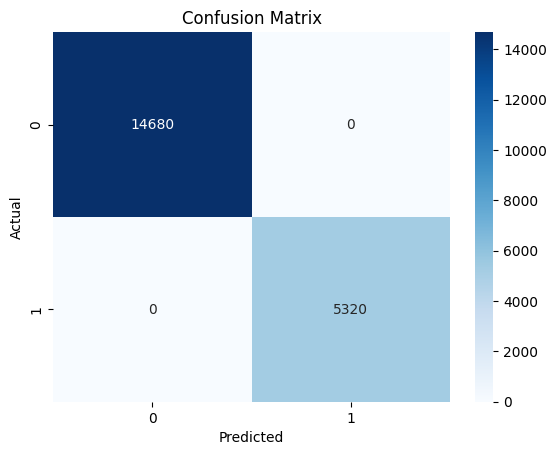

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


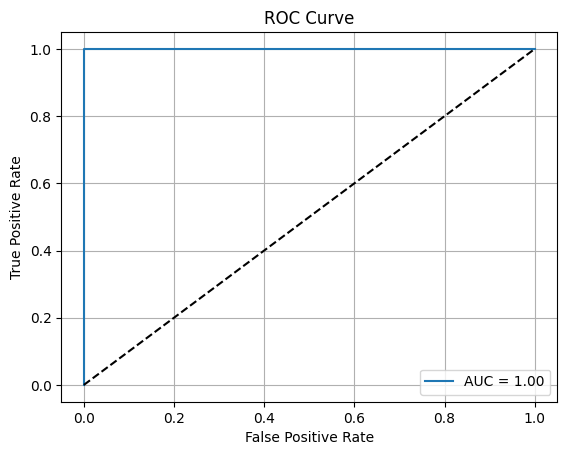

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


📈 Numeric Feature Distributions


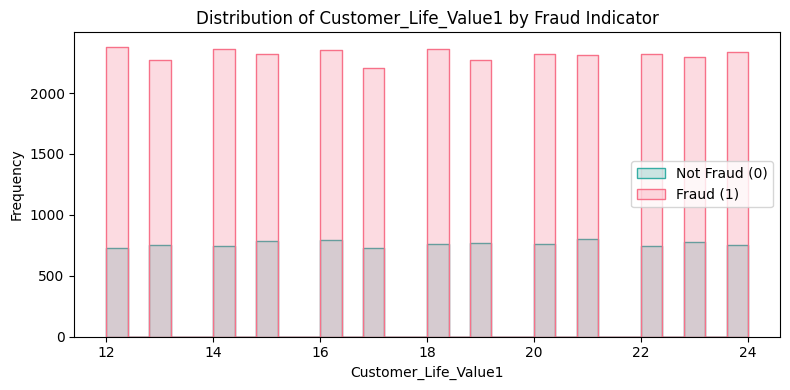

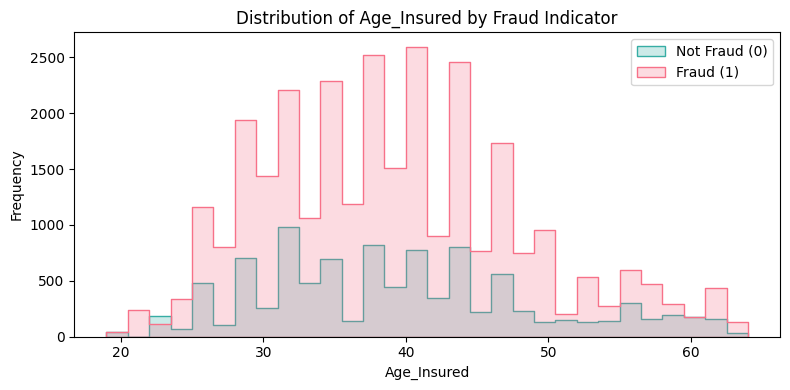

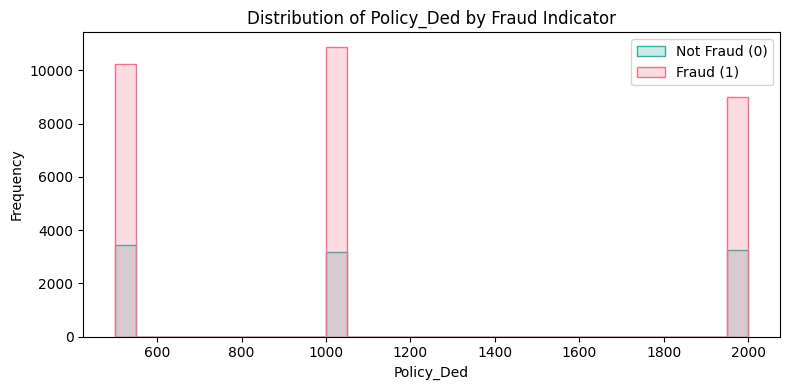

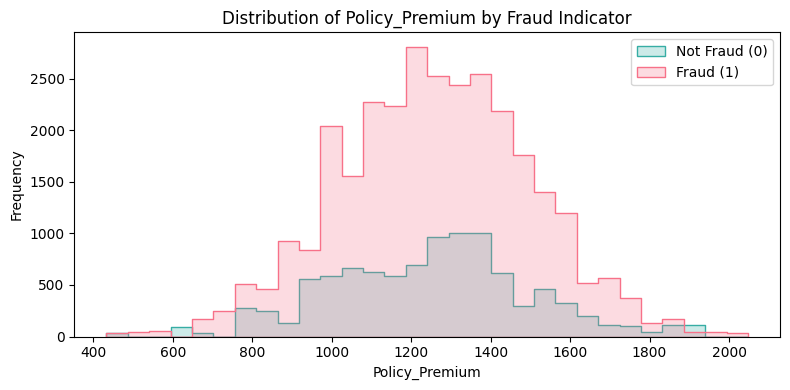

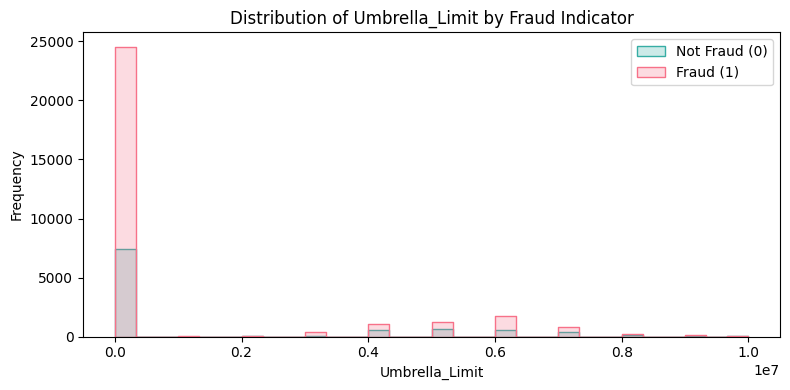

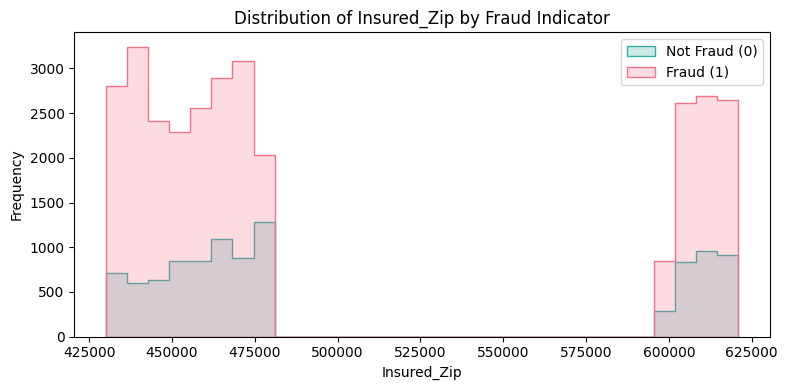

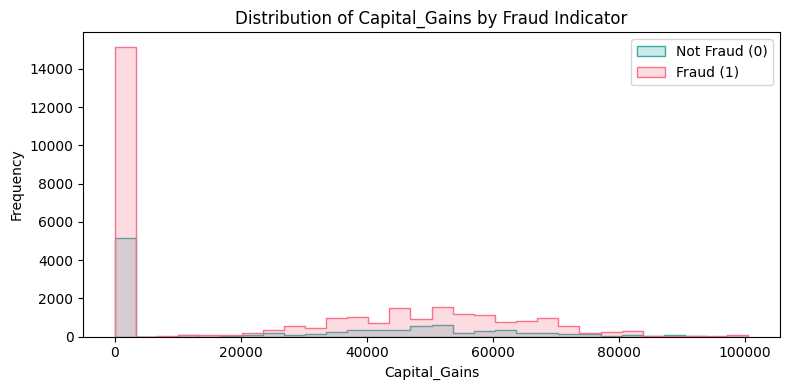

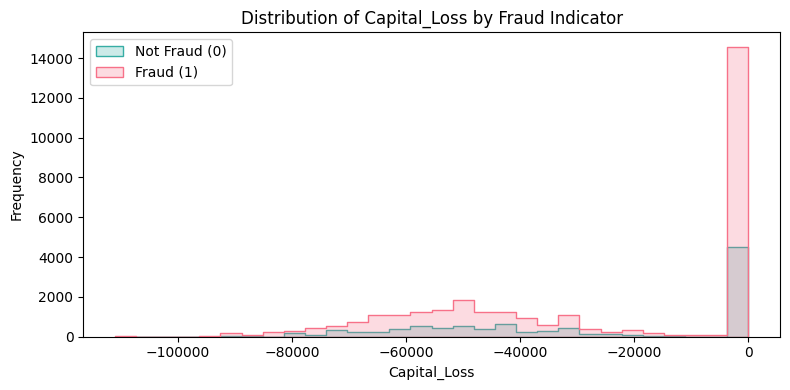

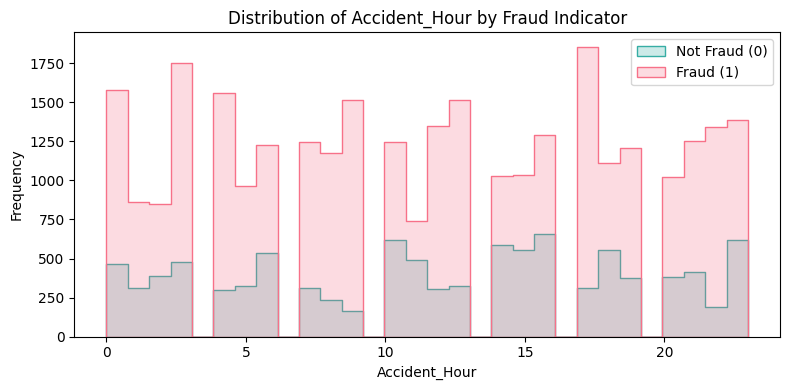

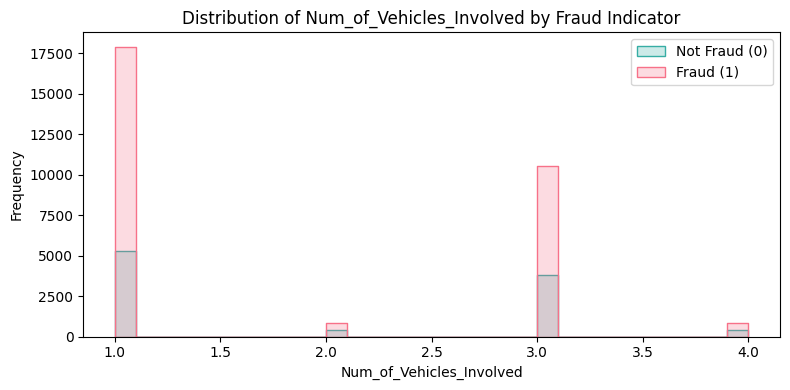

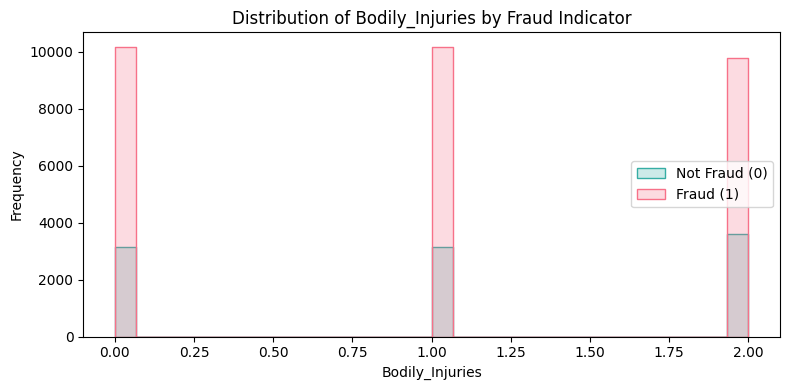

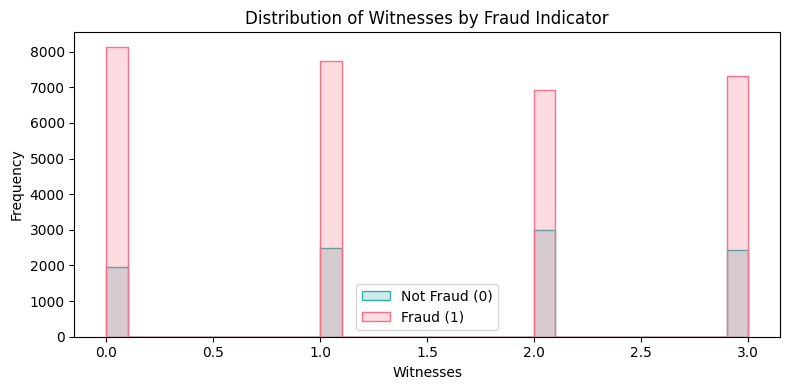

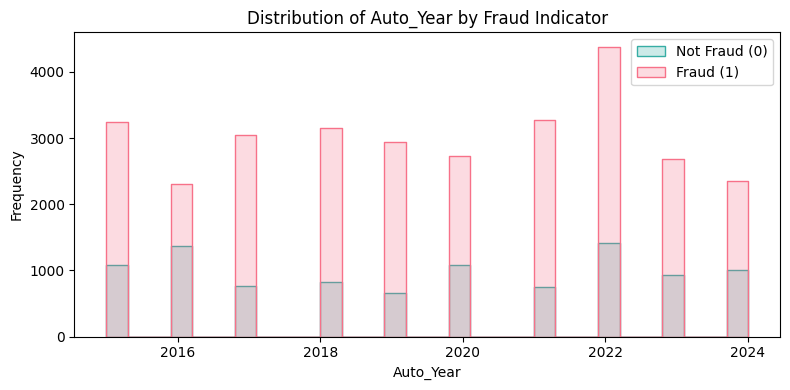

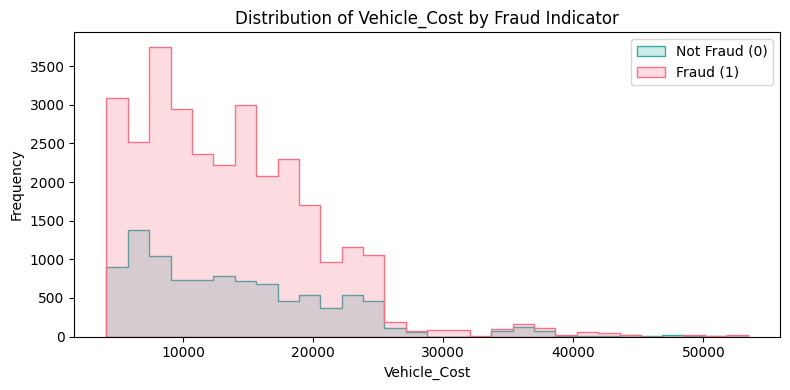

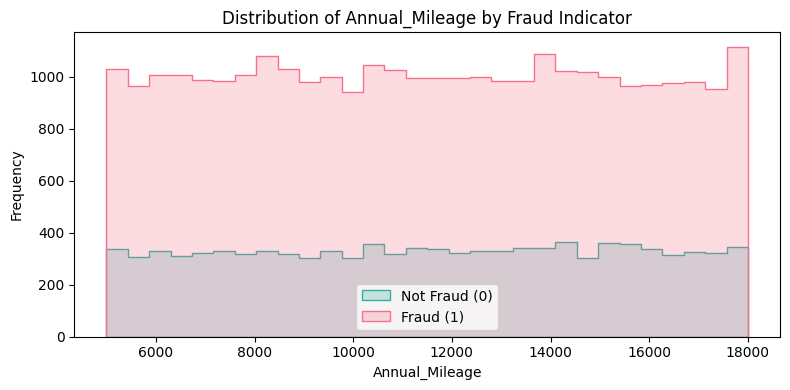

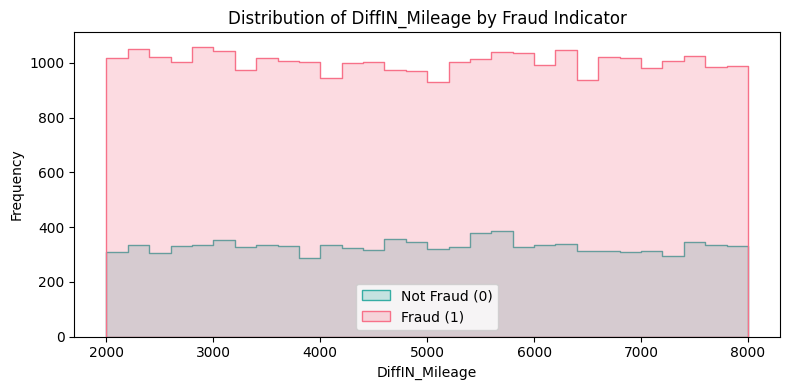

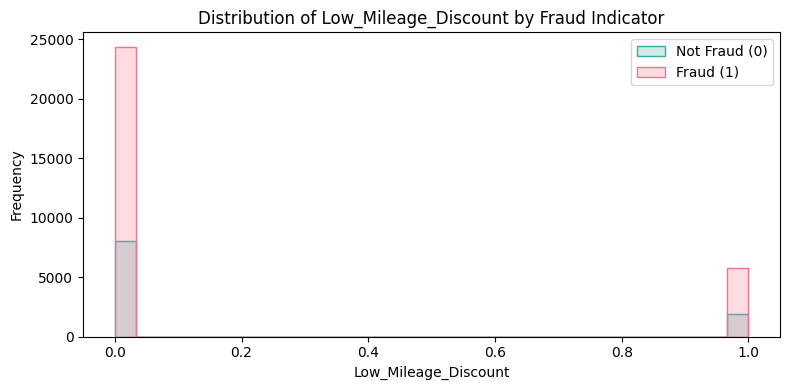

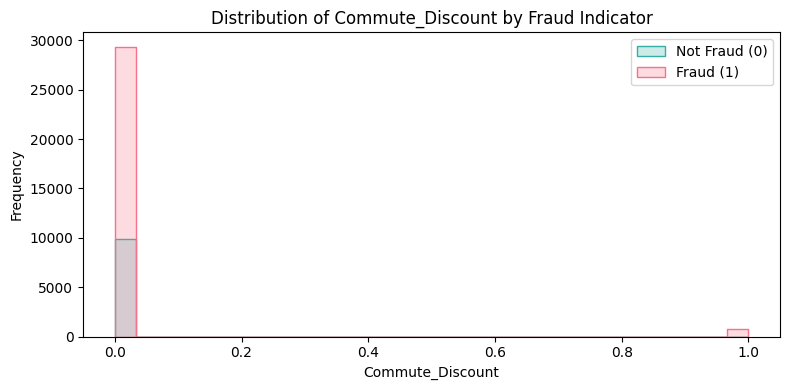

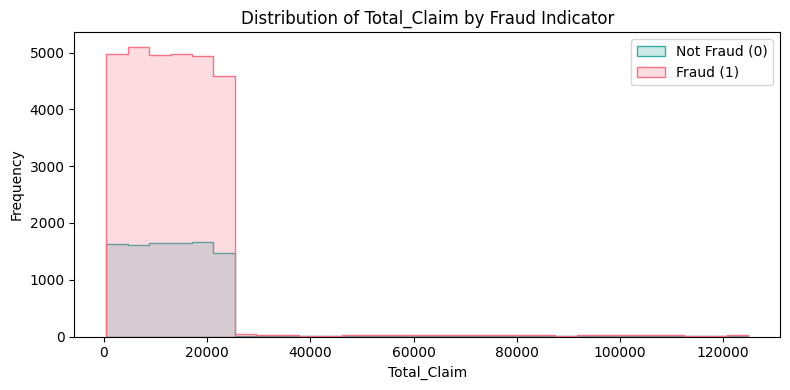

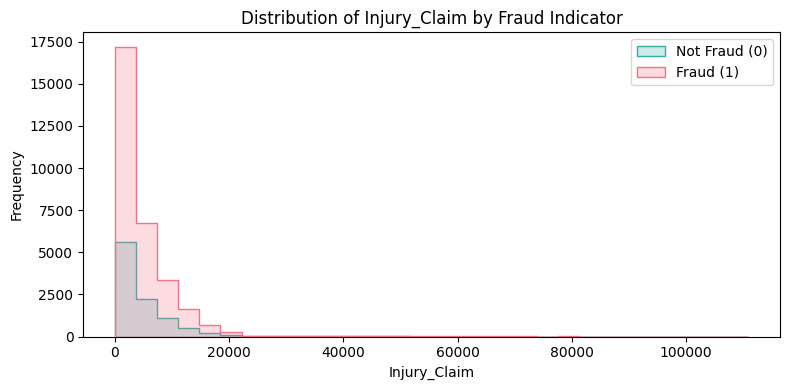

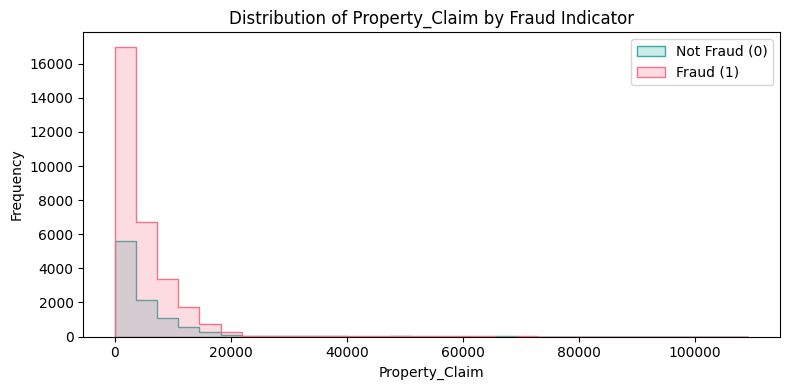

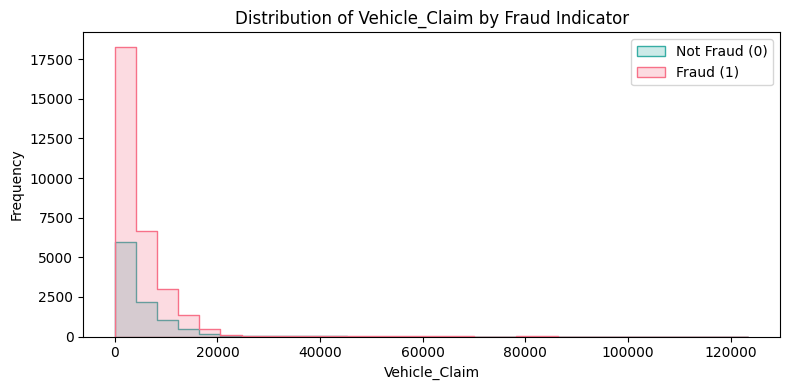

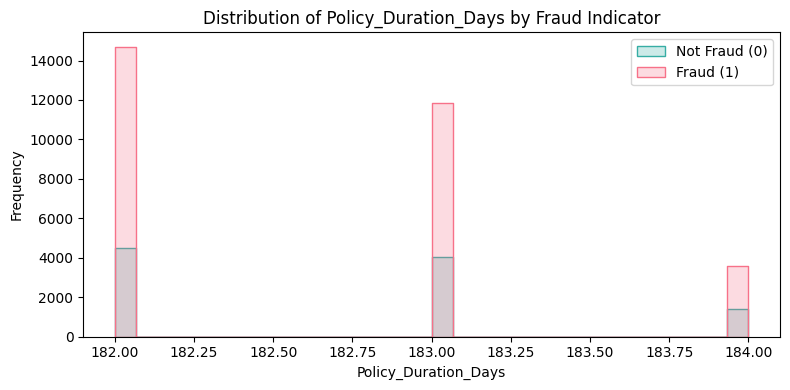

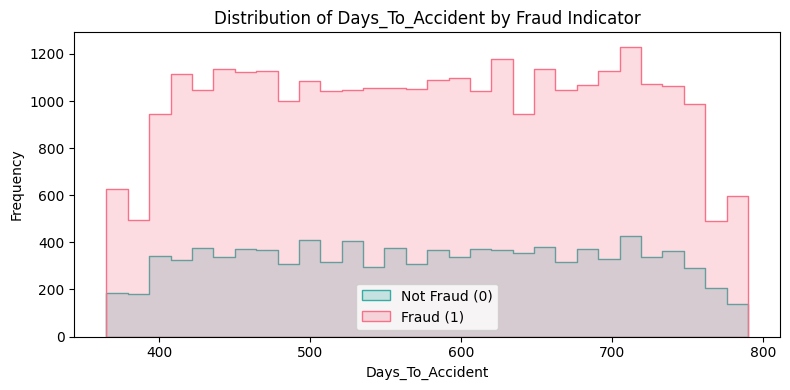

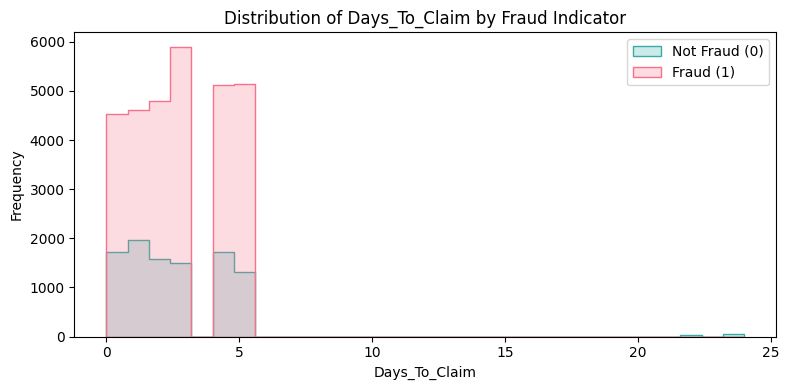

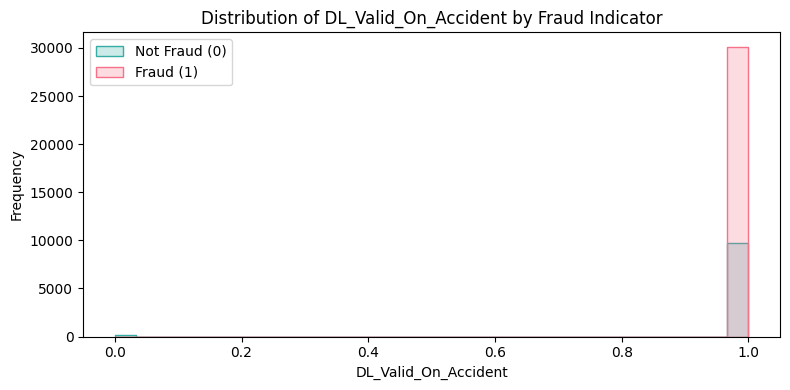

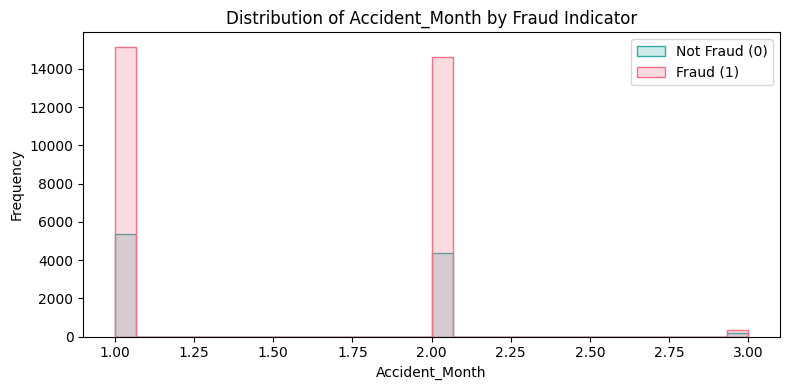

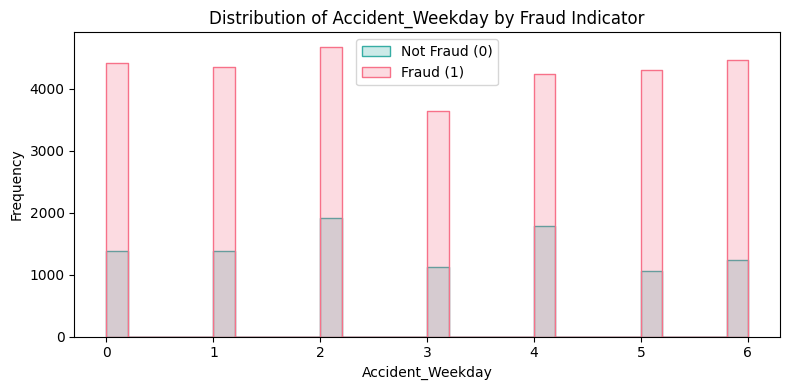

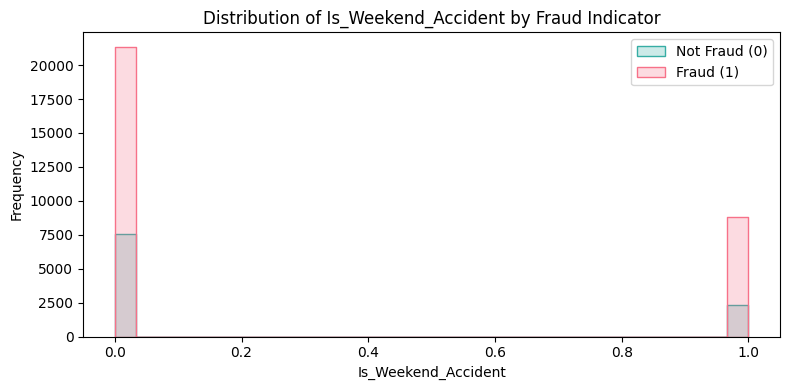

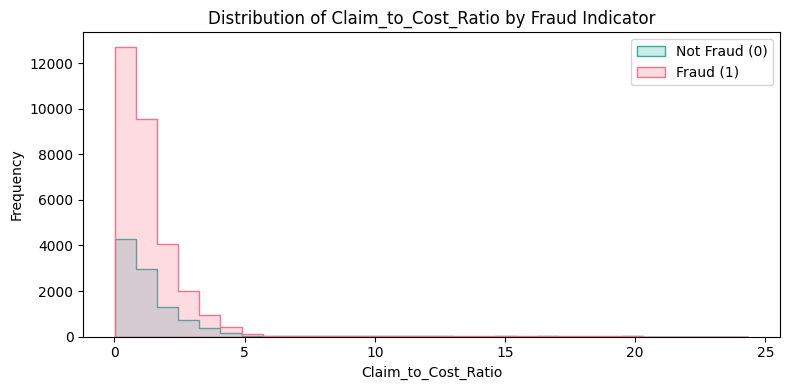

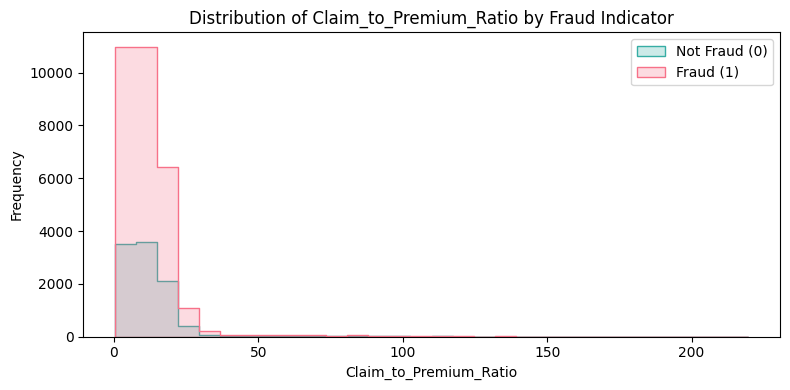

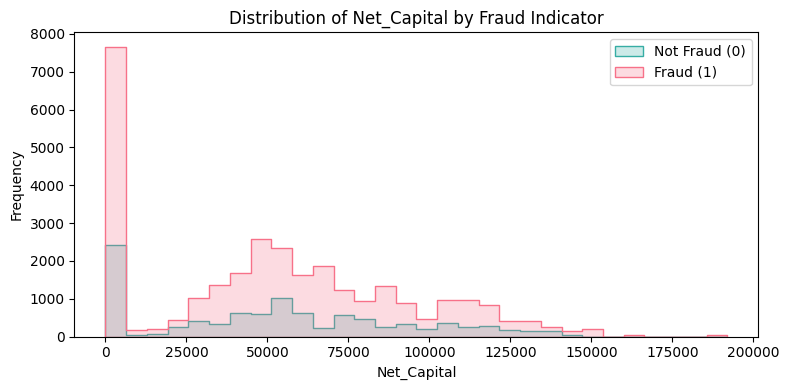

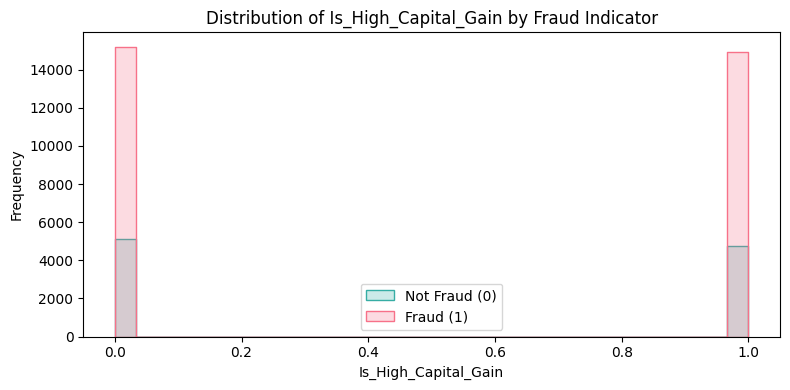

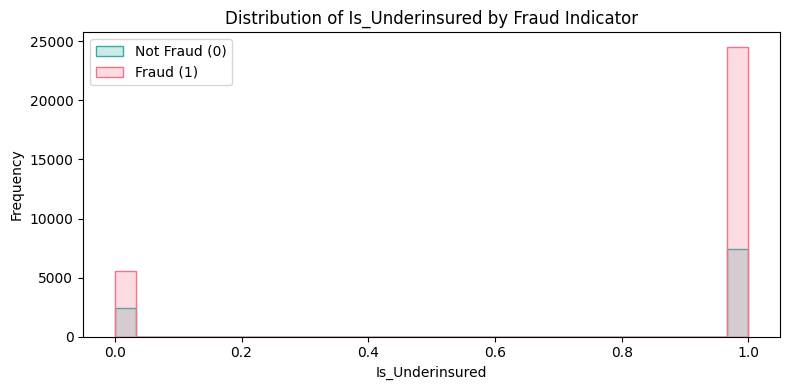

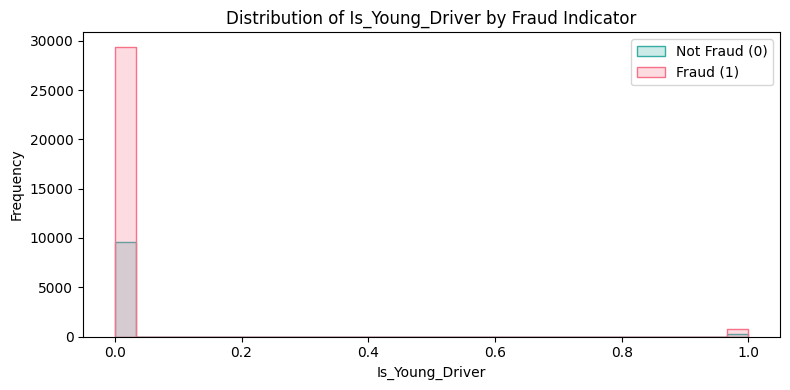

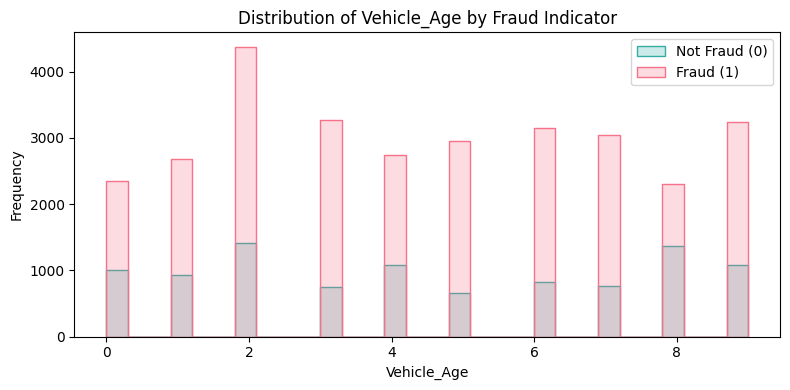

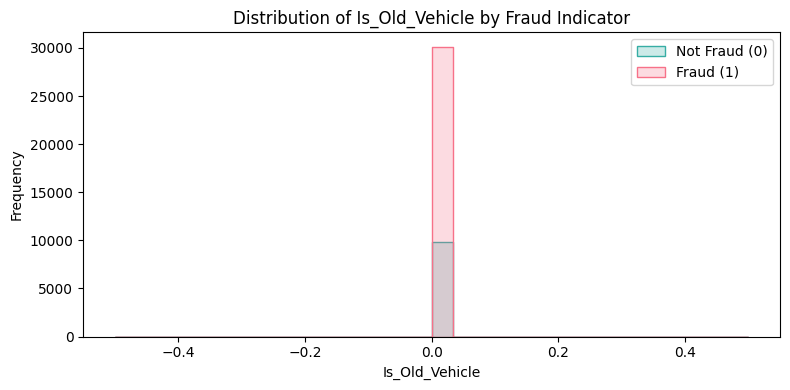

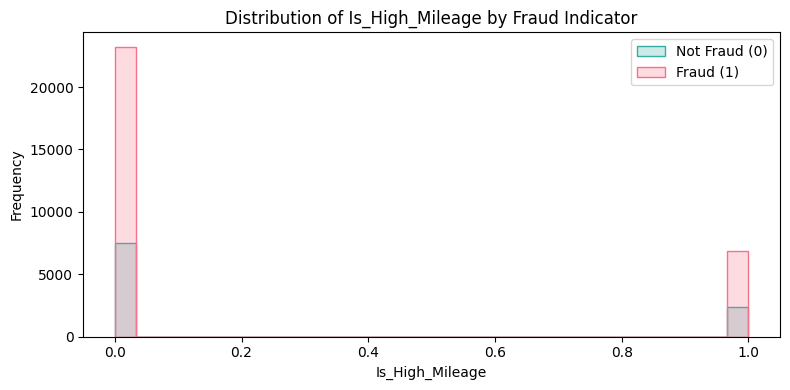

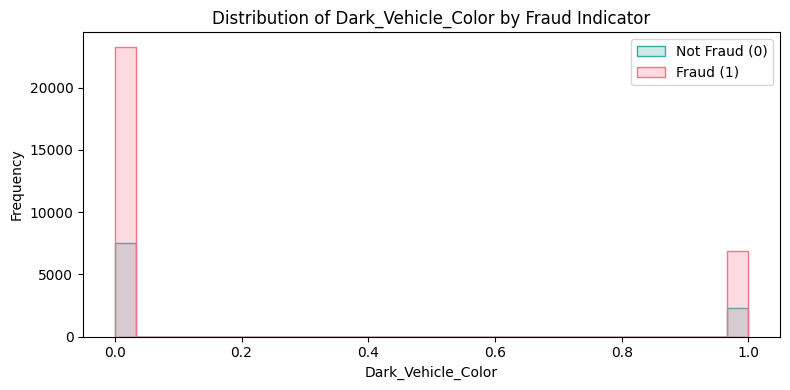

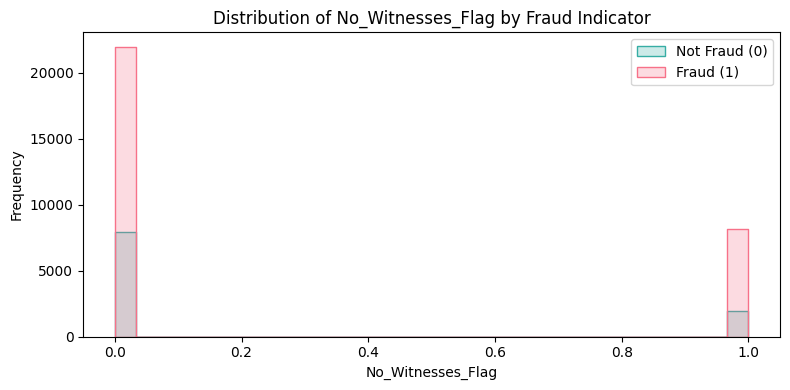

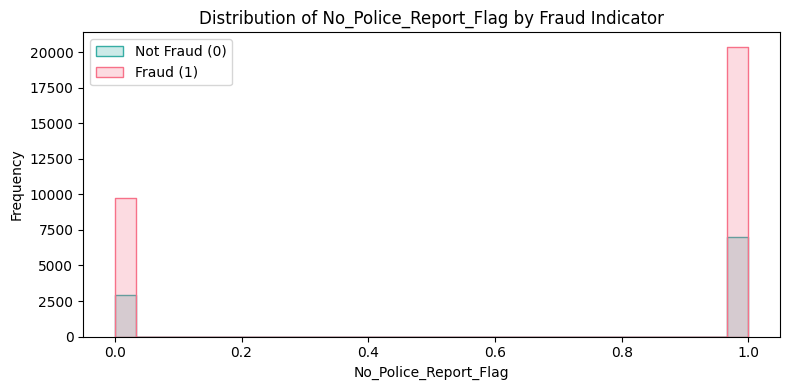

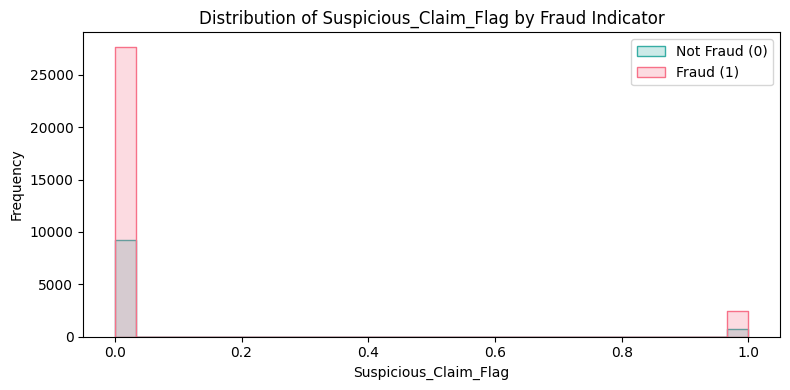

📦 Boxplots by Fraud


/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


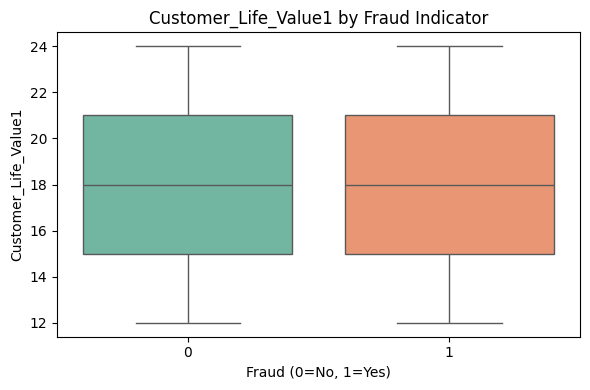

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


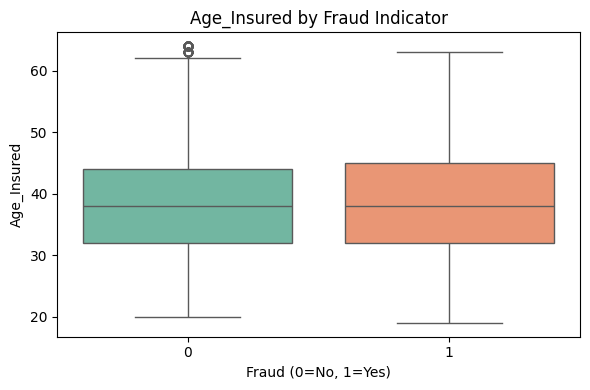

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


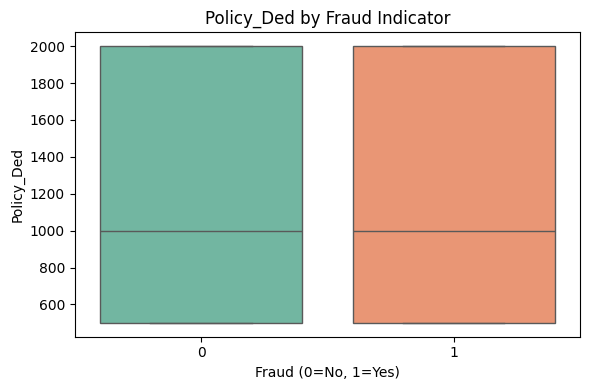

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


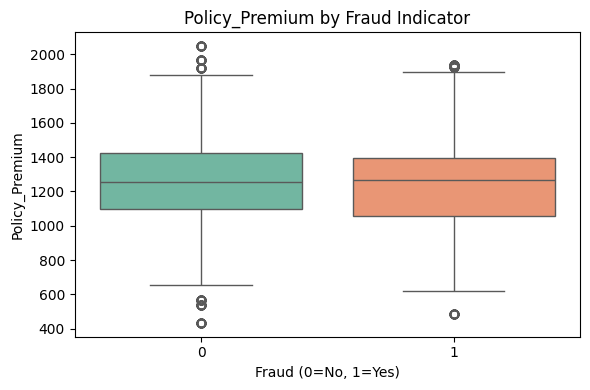

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


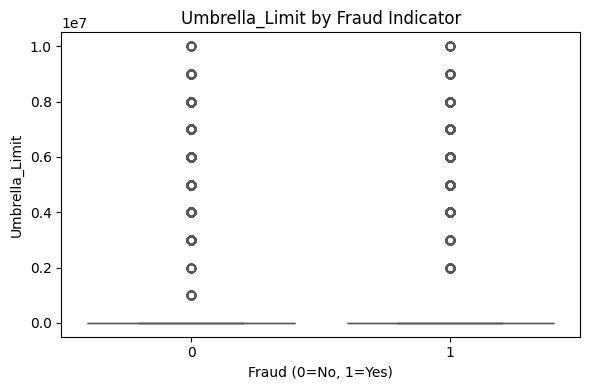

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


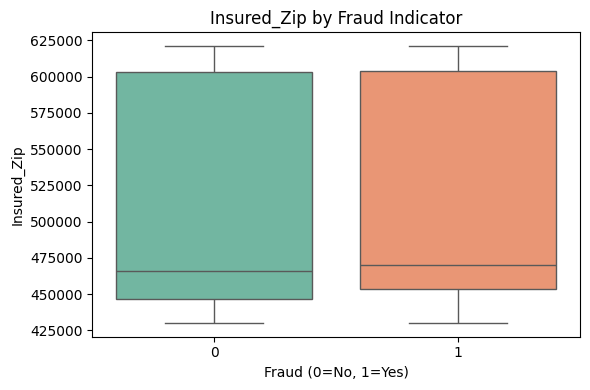

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


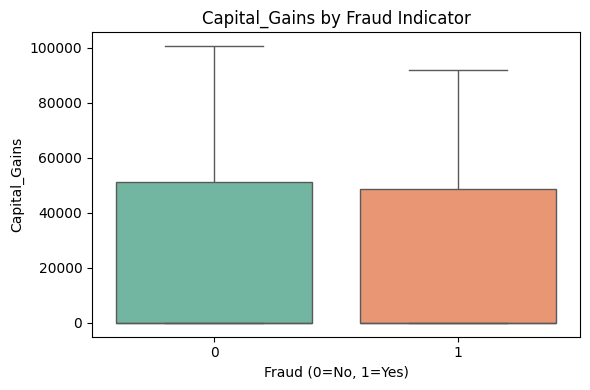

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


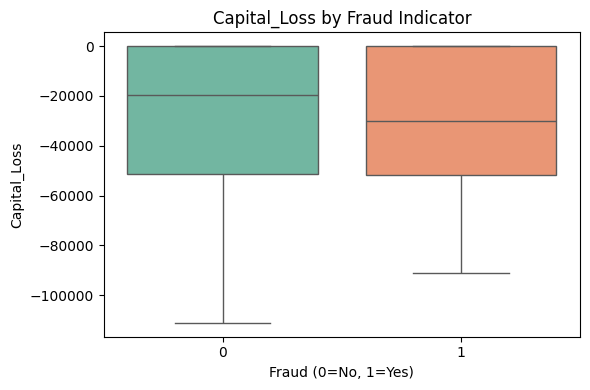

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


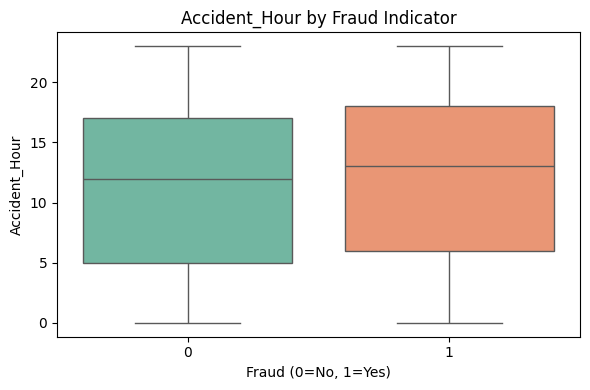

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


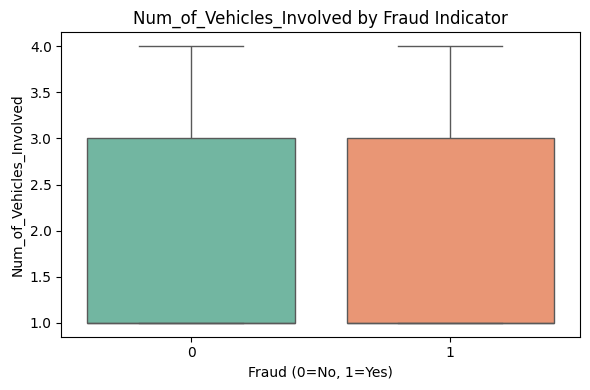

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


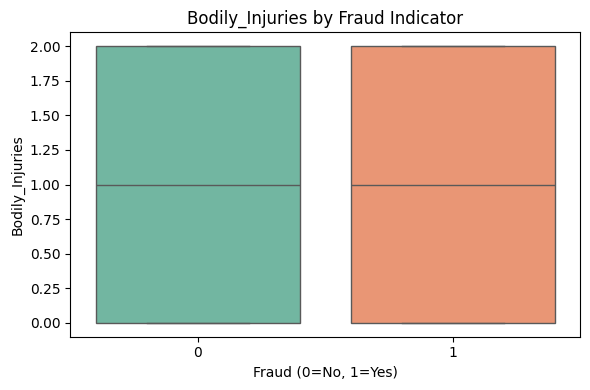

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


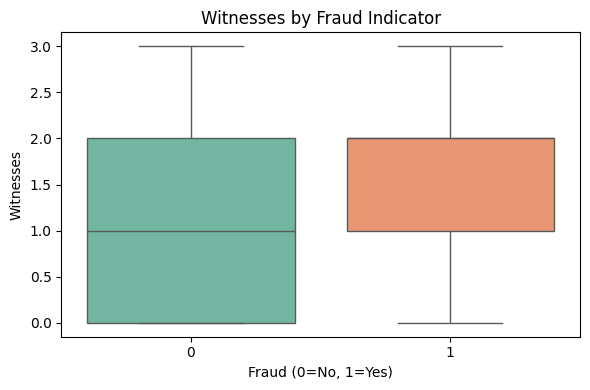

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


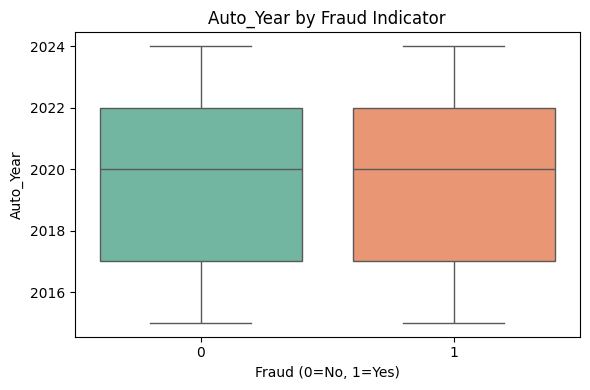

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


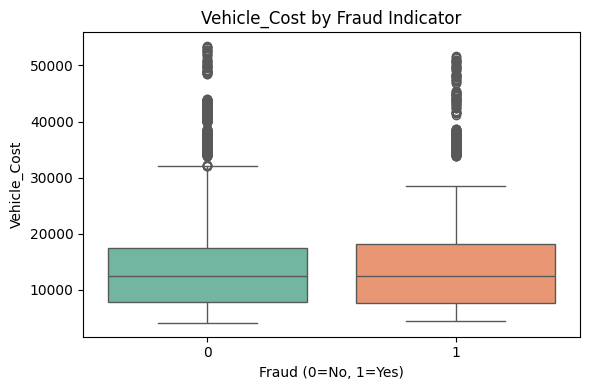

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


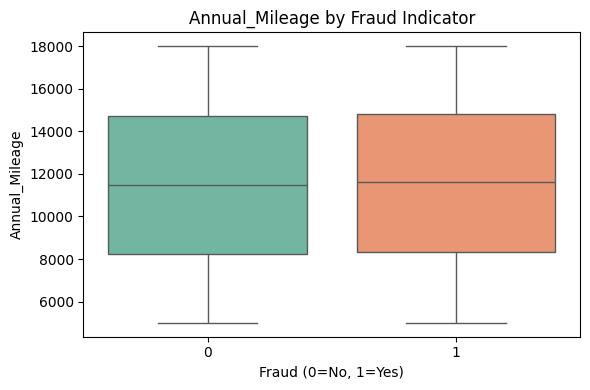

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


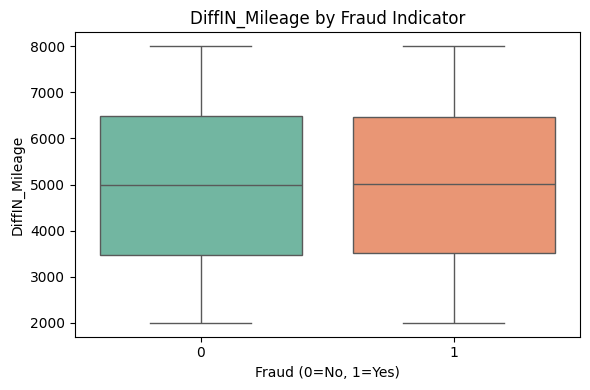

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


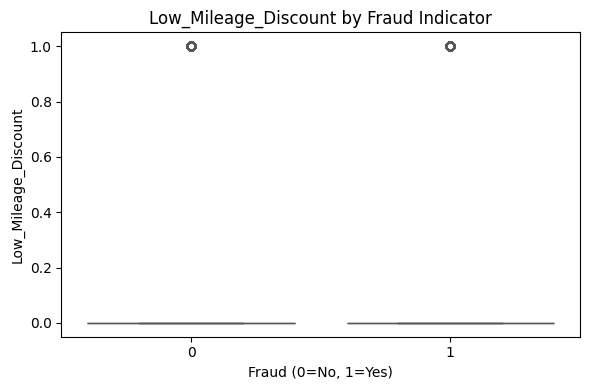

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


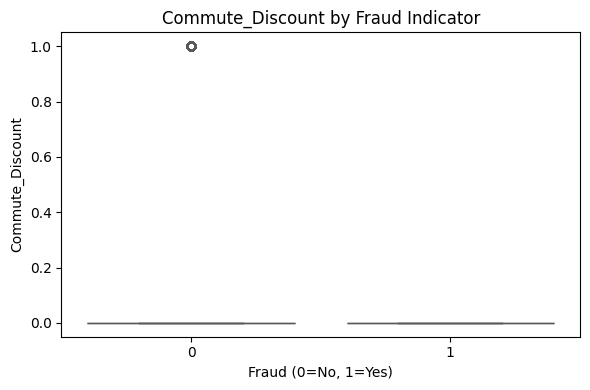

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


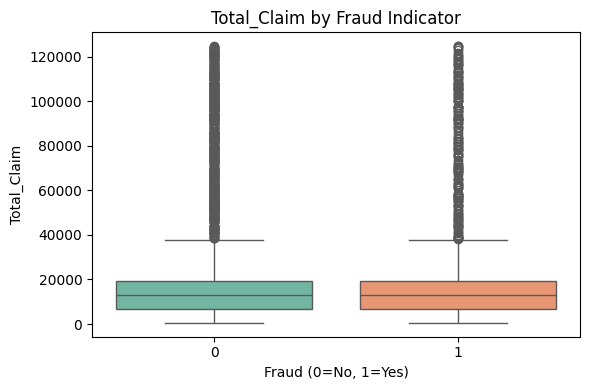

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


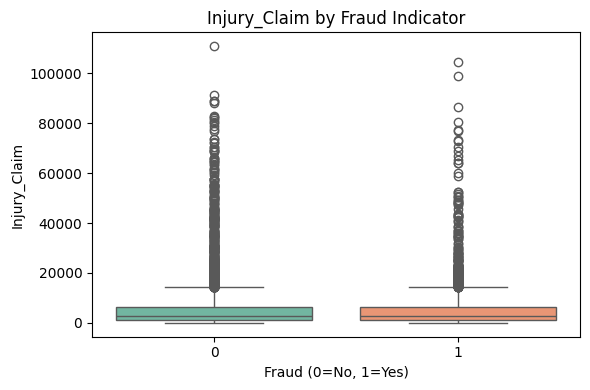

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


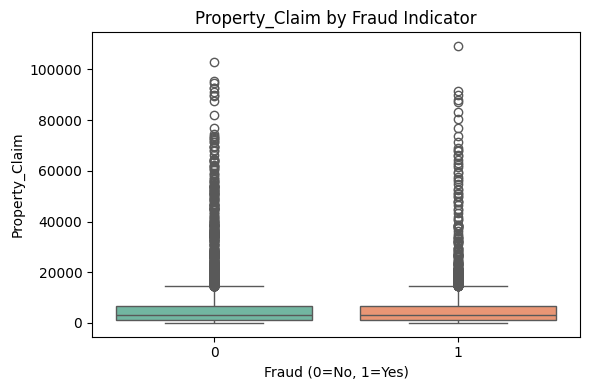

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


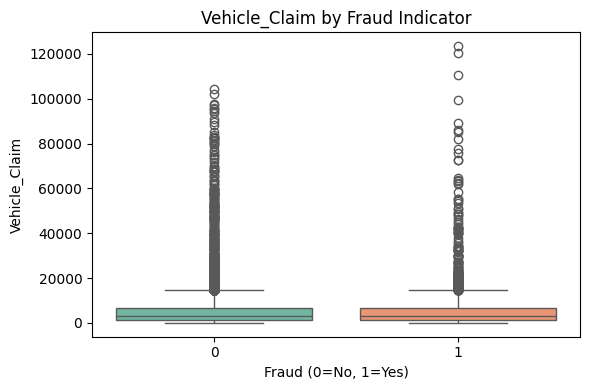

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


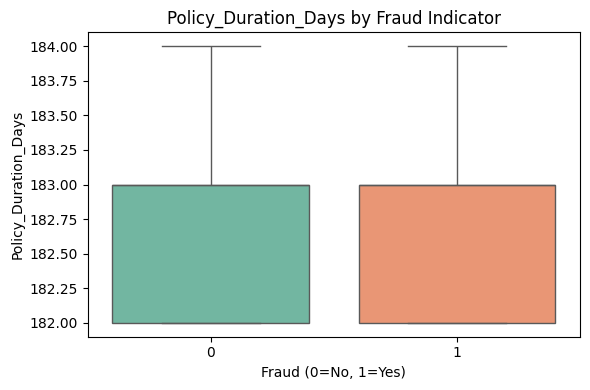

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


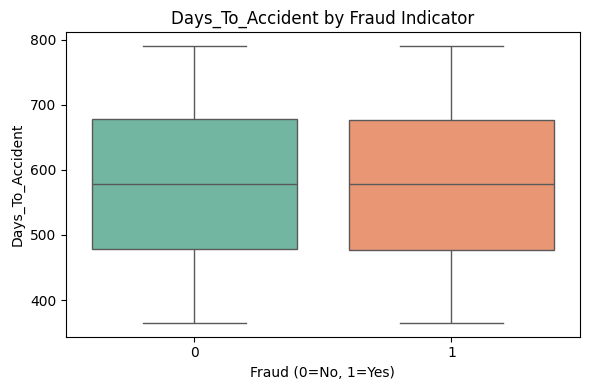

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


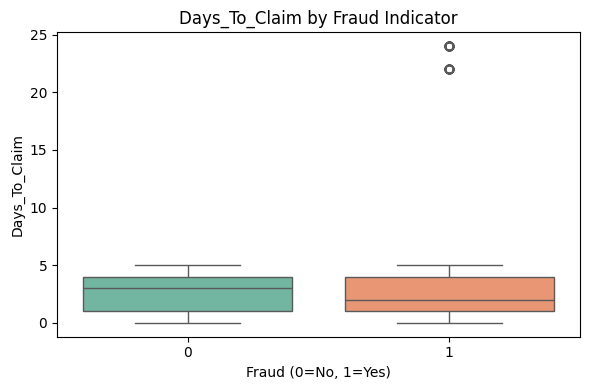

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


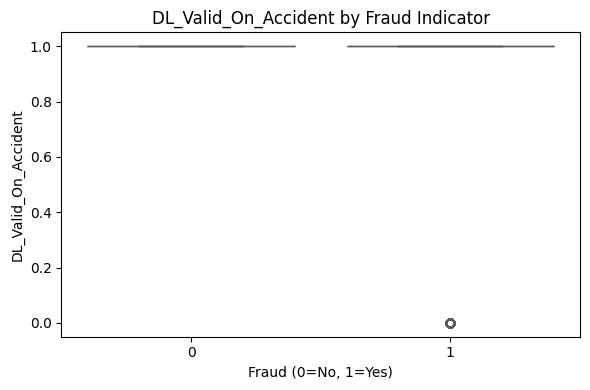

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


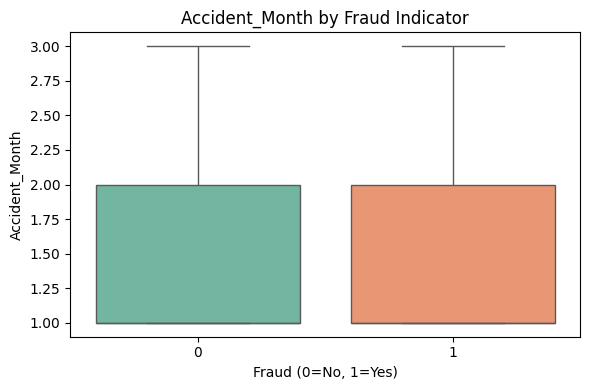

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


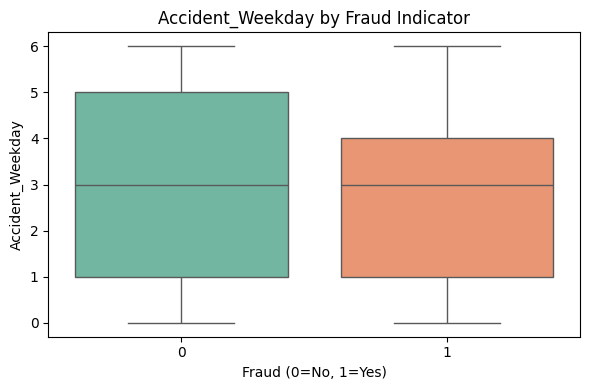

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


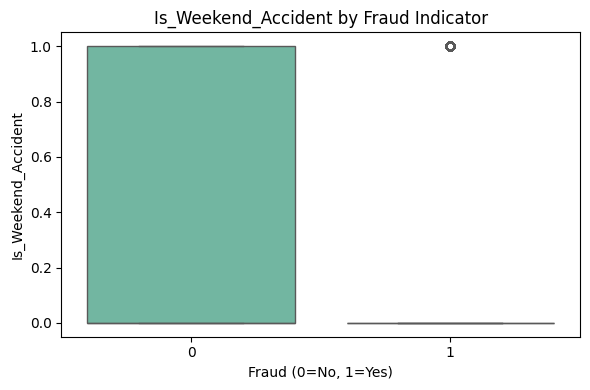

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


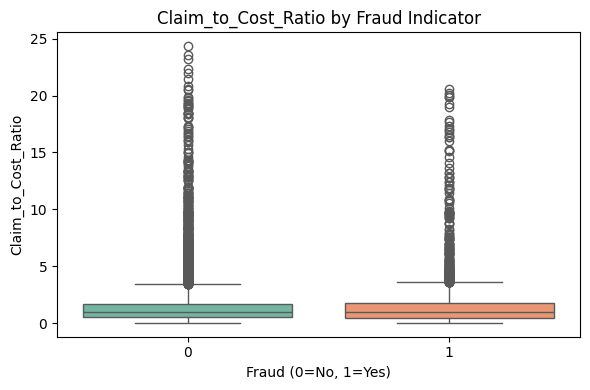

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


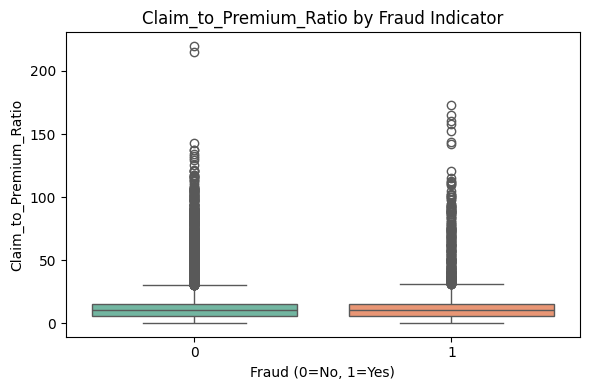

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


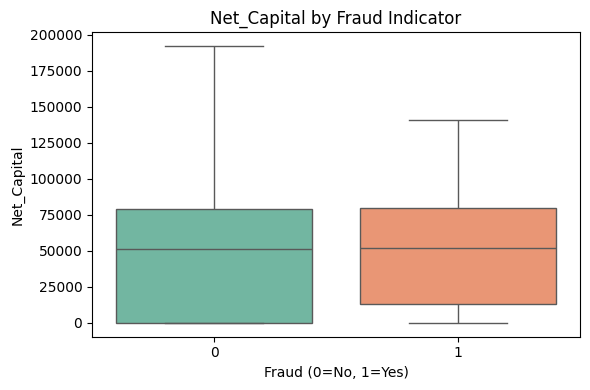

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


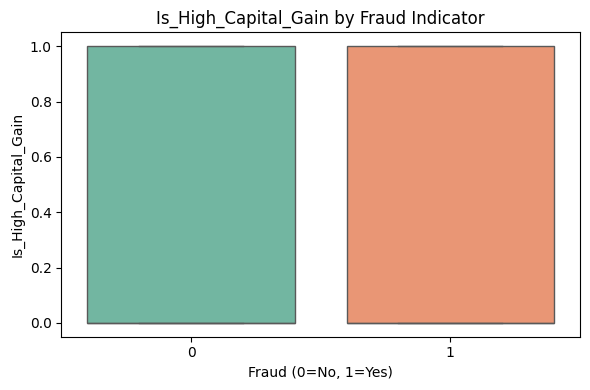

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


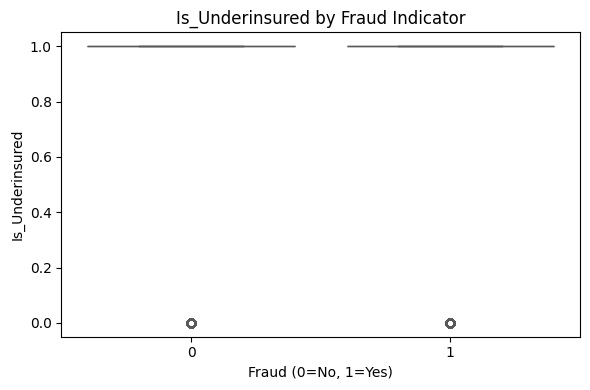

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


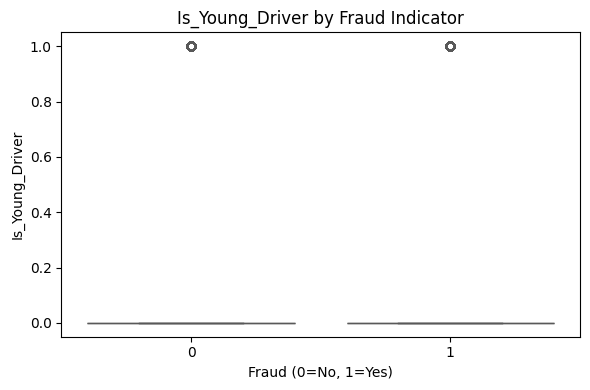

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


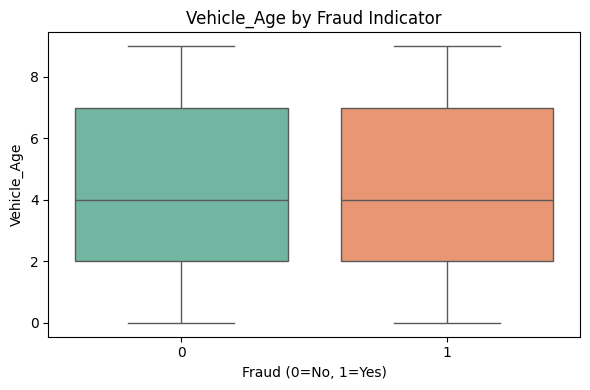

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


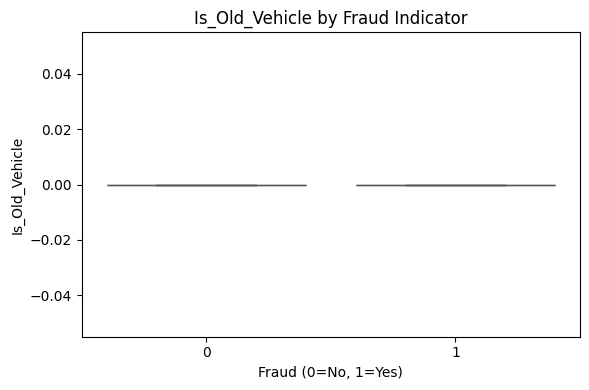

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


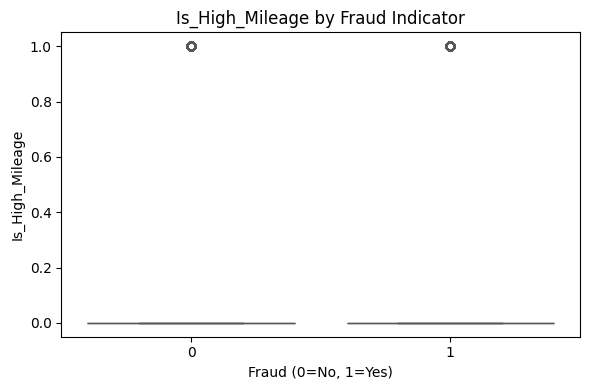

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


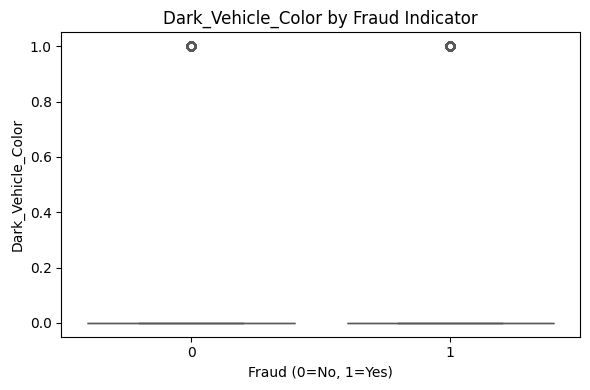

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


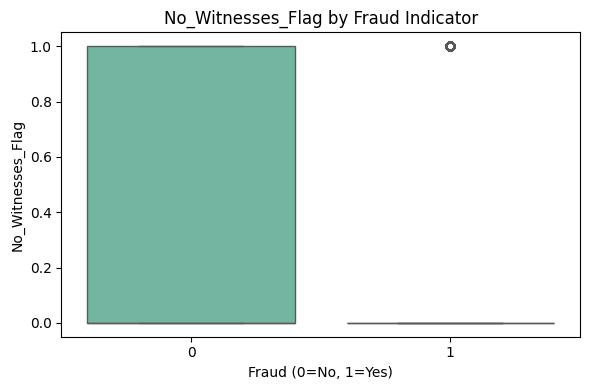

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


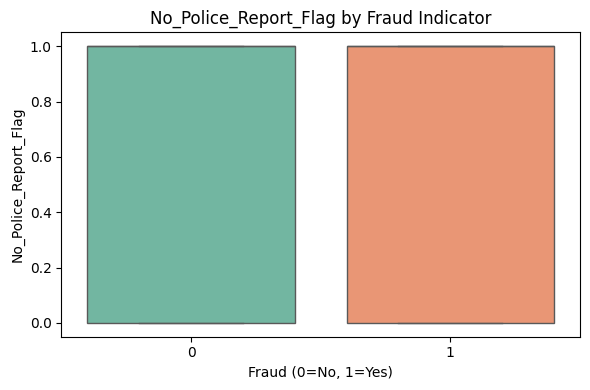

/tmp/ipython-input-7-728061503.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")


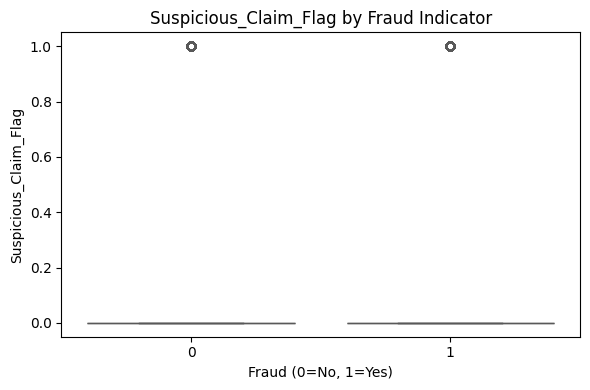

📊 Categorical Feature Counts


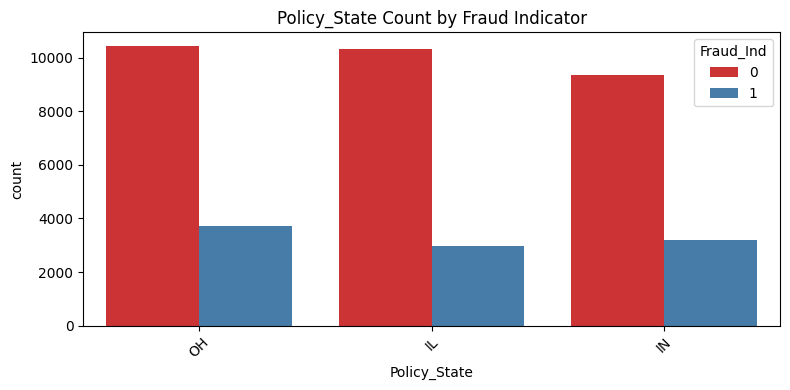

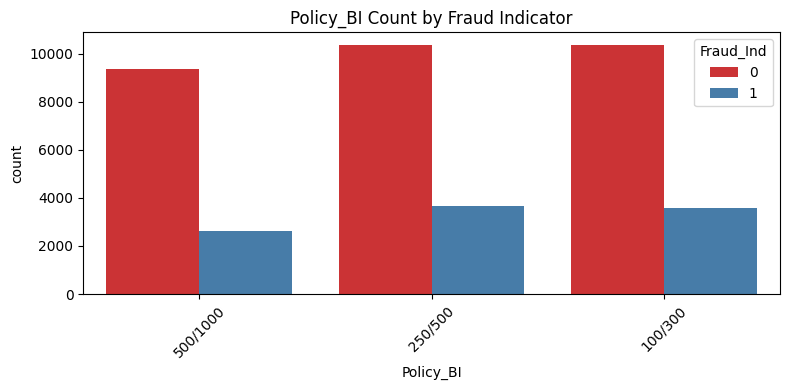

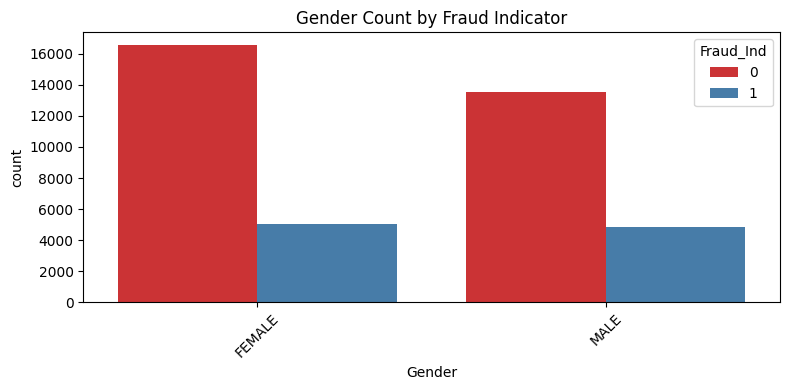

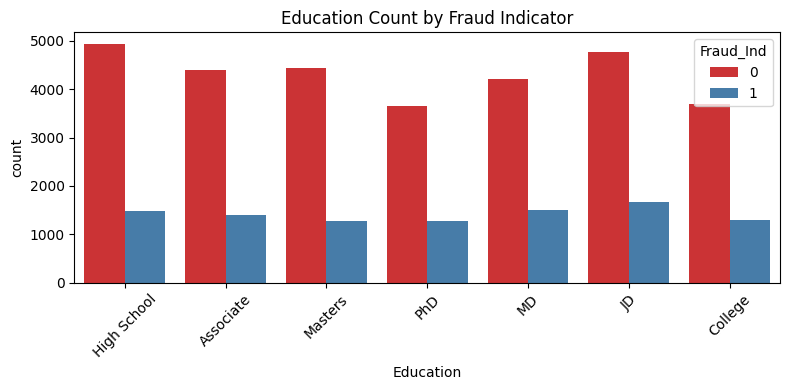

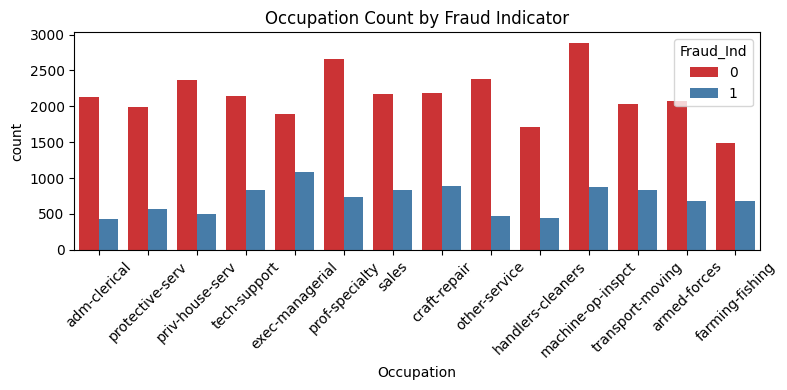

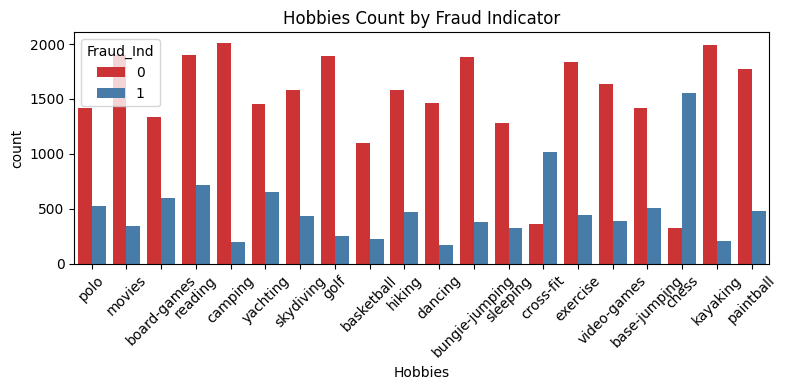

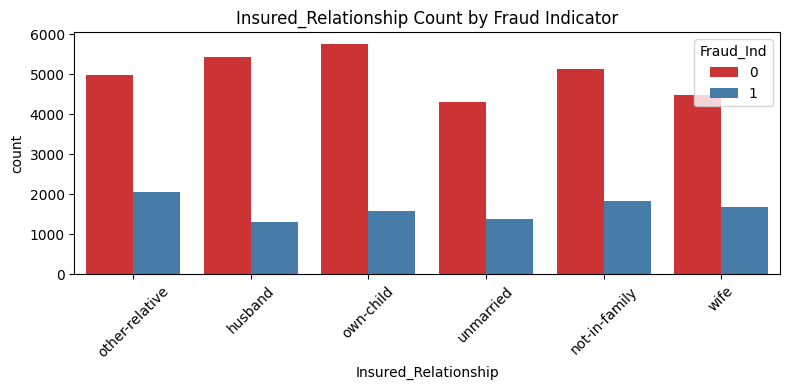

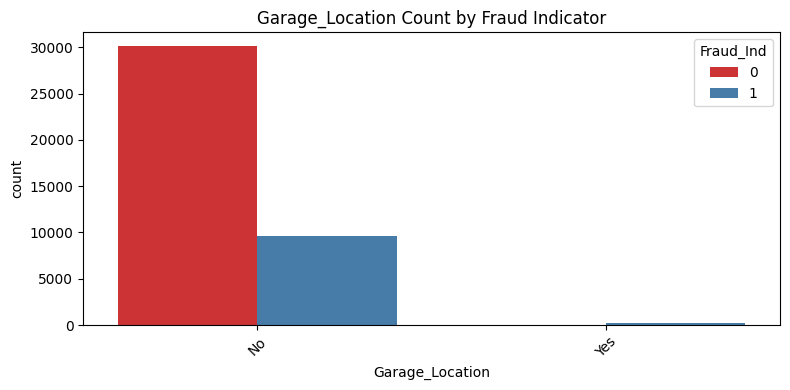

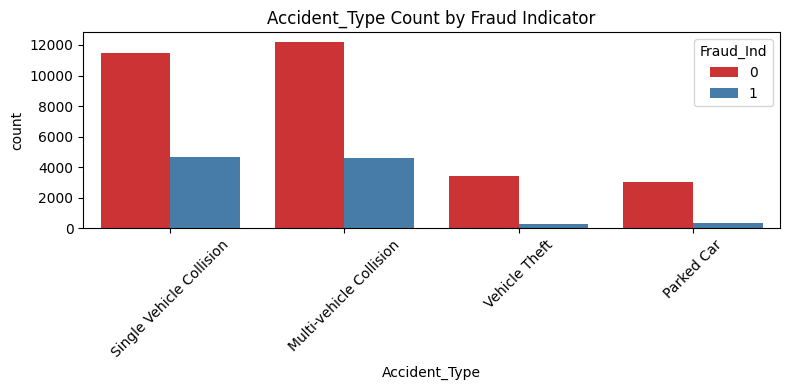

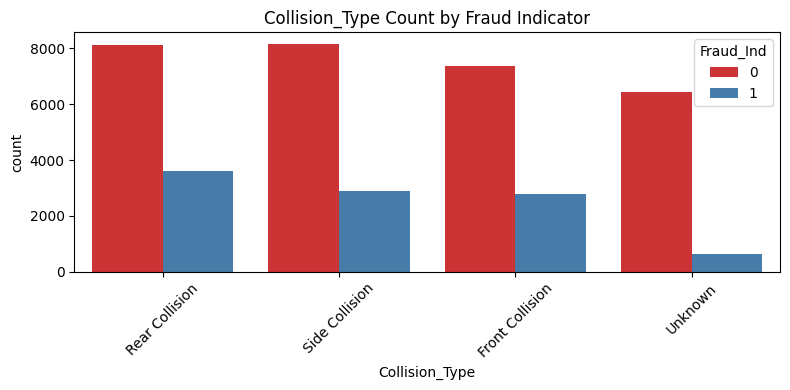

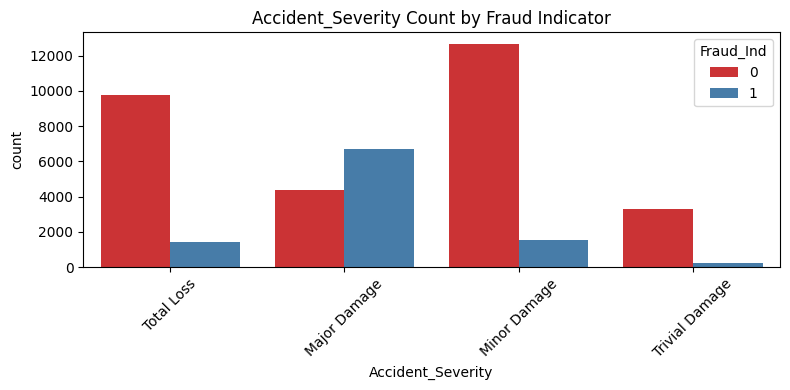

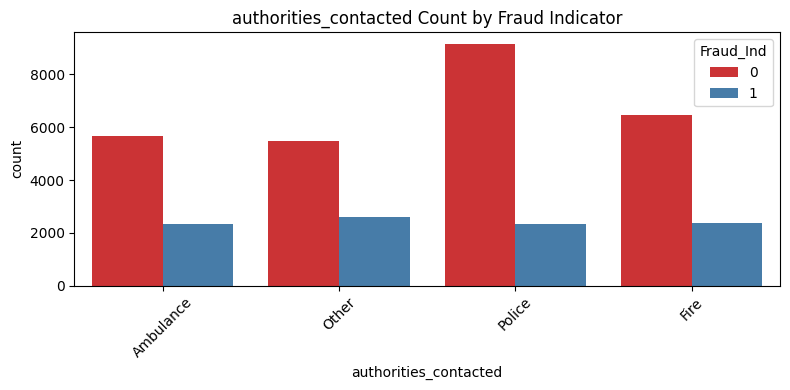

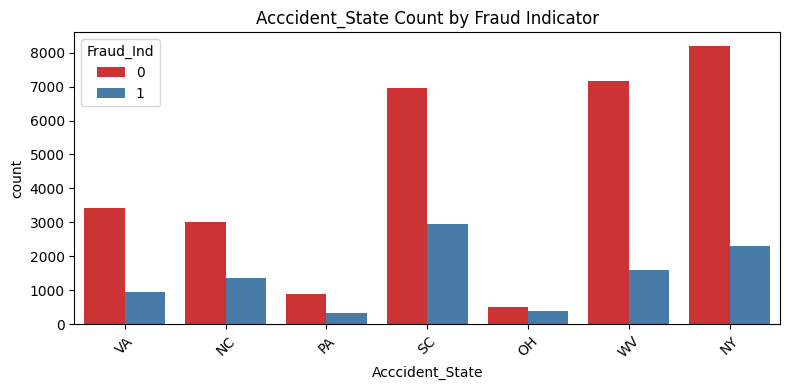

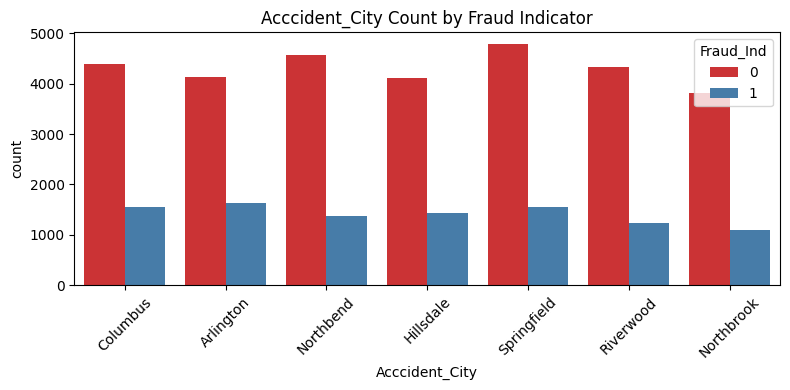

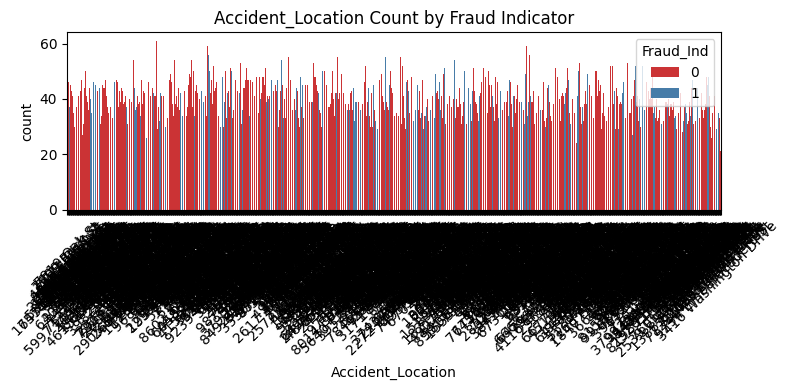

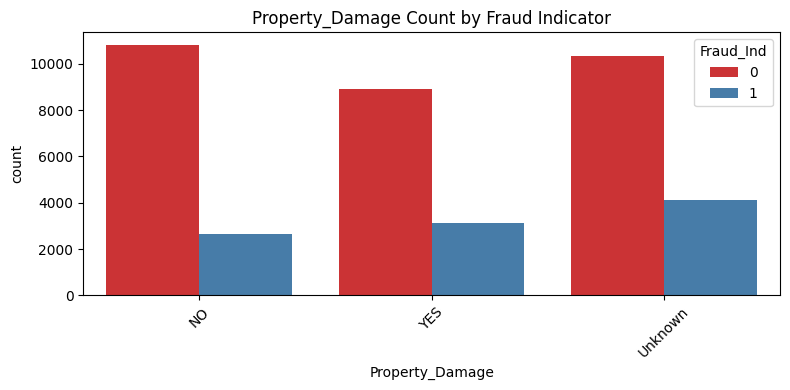

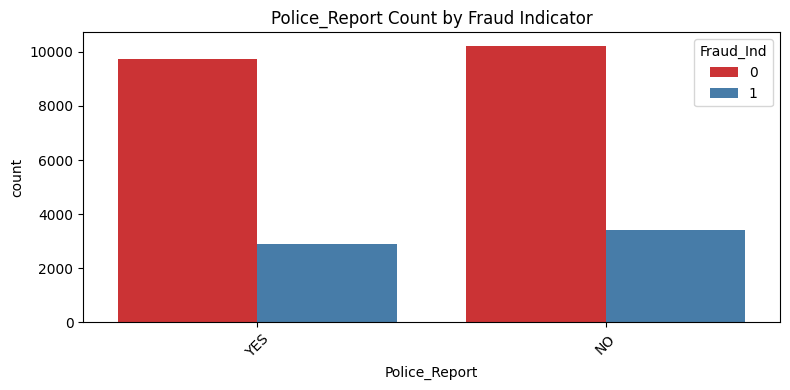

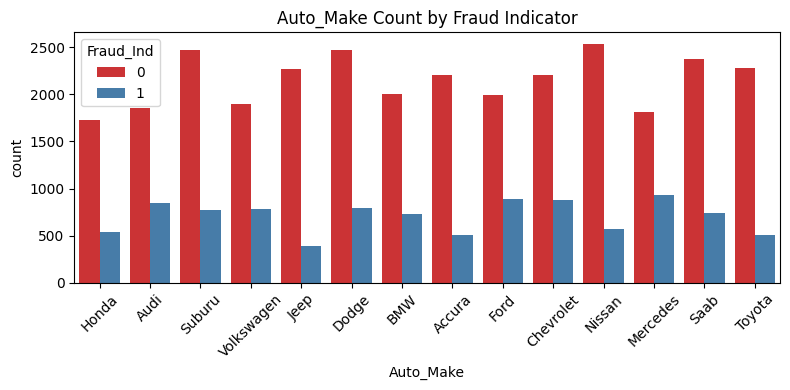

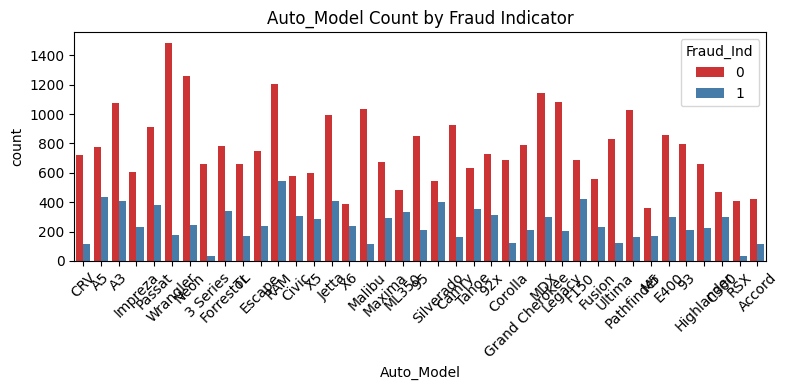

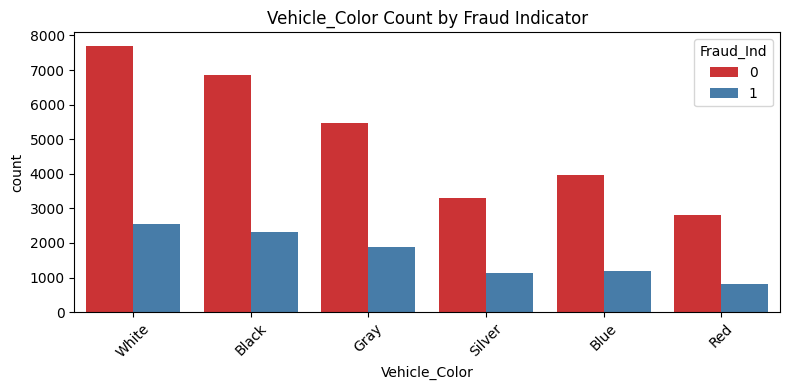

🔗 Correlation Heatmap


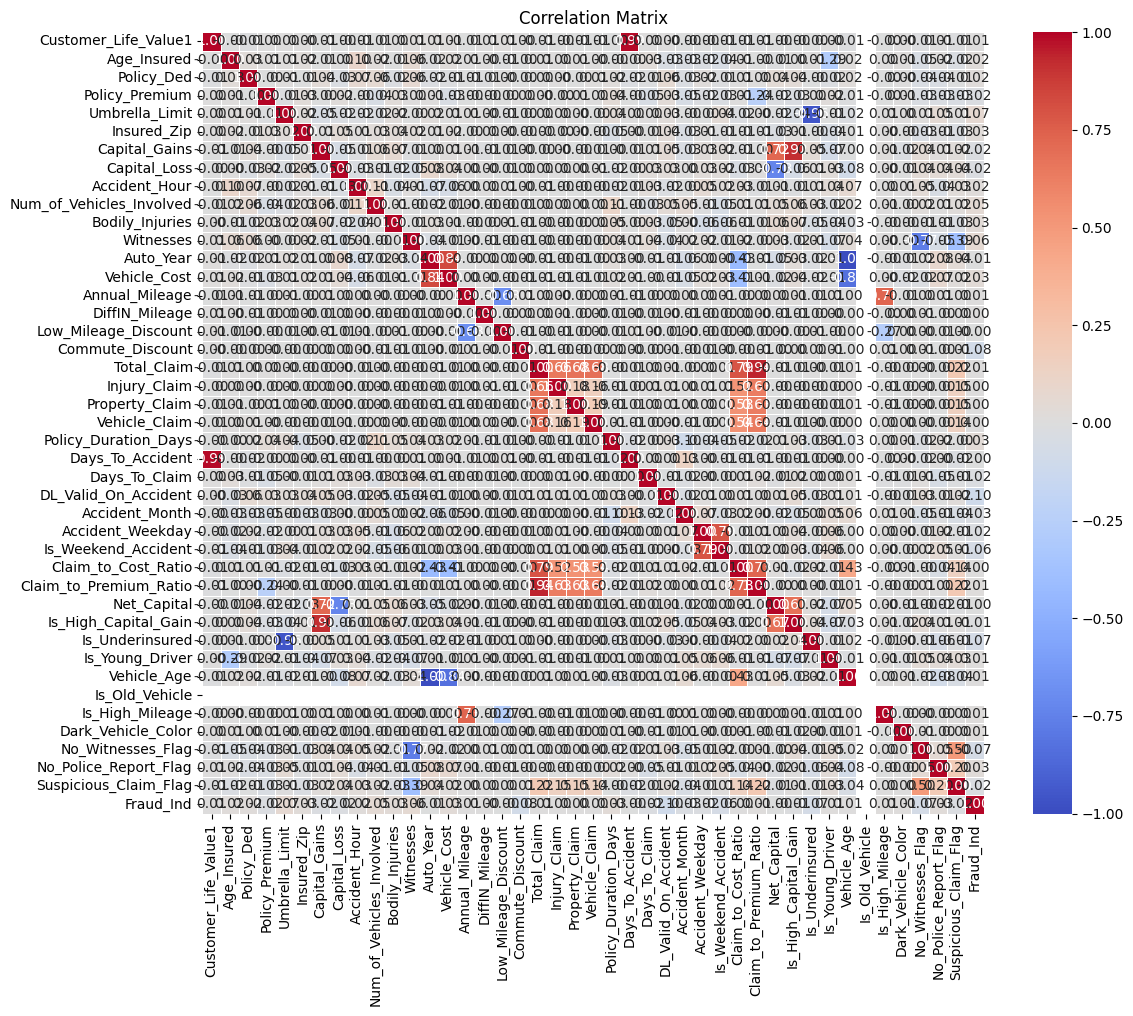

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use full training set
df = train_df.copy()

# === Split Features ===
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=['Fraud_Ind']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# === Plot: Numeric Distributions ===
print("📈 Numeric Feature Distributions")
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Fraud_Ind', bins=30, palette="husl", element="step")

    plt.title(f"Distribution of {col} by Fraud Indicator")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend(["Not Fraud (0)", "Fraud (1)"])
    plt.tight_layout()
    plt.show()

# === Plot: Boxplots for Numerical Features by Fraud_Ind ===
print("📦 Boxplots by Fraud")
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Fraud_Ind', y=col, palette="Set2")
    plt.title(f"{col} by Fraud Indicator")
    plt.xlabel("Fraud (0=No, 1=Yes)")
    plt.tight_layout()
    plt.show()

# === Plot: Categorical Counts ===
print("📊 Categorical Feature Counts")
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='Fraud_Ind', palette="Set1")
    plt.title(f"{col} Count by Fraud Indicator")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Correlation Heatmap ===
print("🔗 Correlation Heatmap")
plt.figure(figsize=(12, 10))
corr = df[numeric_features + ['Fraud_Ind']].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# === Re-train best model on full training data ===
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# === Make predictions on validation set ===
val_preds = best_model.predict(X_val)
val_probs = best_model.predict_proba(X_val)[:, 1]  # for ROC AUC

# === Evaluate on validation set ===
accuracy = accuracy_score(y_val, val_preds)
precision = precision_score(y_val, val_preds, zero_division=0)
recall = recall_score(y_val, val_preds, zero_division=0)
f1 = f1_score(y_val, val_preds)
roc_auc = roc_auc_score(y_val, val_probs)

print(f"\n🎯 Final Evaluation on Validation Set using {best_model_name}:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")



🎯 Final Evaluation on Validation Set using RandomForest:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
ROC AUC:   1.0000


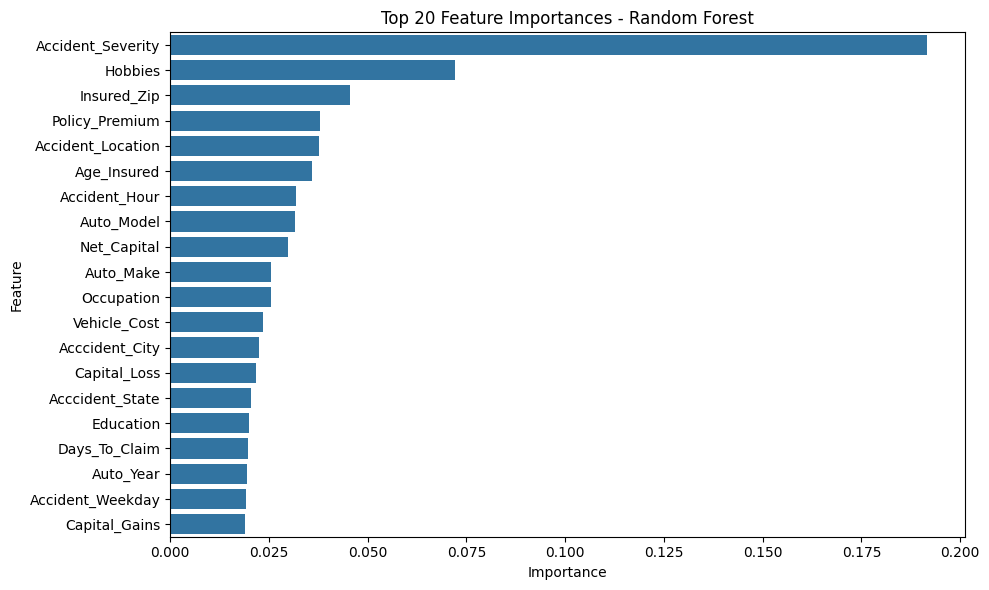

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = common_cols.drop(datetime_cols) if datetime_cols else common_cols
importances = best_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title("Top 20 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save pipeline and model
joblib.dump(best_model, "fraud_model.pkl")
joblib.dump(pipeline, "preprocess_pipeline.pkl")
joblib.dump(encoders, "label_encoders.pkl")


['label_encoders.pkl']

In [ ]:
import joblib

# Assuming best_model is your trained RandomForestClassifier
joblib.dump(best_model, "random_forest_model.joblib")


['random_forest_model.joblib']

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Assuming you have already trained your model and preprocessing pipeline
joblib.dump(best_model, "random_forest_model.joblib")
joblib.dump(pipeline, "preprocessing_pipeline.joblib")


['preprocessing_pipeline.joblib']

In [ ]:
joblib.dump(encoders, "label_encoders.joblib")
joblib.dump(common_cols.tolist(), "model_features.joblib")


['model_features.joblib']

In [ ]:
import joblib

# Assuming `encoders` is a dictionary of LabelEncoders
joblib.dump(encoders, "label_encoders.joblib")


['label_encoders.joblib']